In [27]:
'''
Some libs for math
'''
from math import log2
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import tikzplotlib
from sklearn.linear_model import LogisticRegression
import math

frac_cache = dict()

def frac(n:int):
    """
    Calculate the frac: n!
    """
    if n <= 0:
        return 1
    if n in frac_cache:
        return frac_cache[n]
    frac_cache[n] = frac(n-1) * n
    return frac_cache[n]

def comb(n:int,m:int):
    """
    Calculate the combination number: pick m items from n items
    """
    if m>n:
        return 0
    elif m==n:
        return 1
    return (frac(n)/frac(n-m))/frac(m)

random.seed(20220622)

# generate bernoulli r.v.
def bernoulli(p):
    if random.random()<p:
        return 1
    else:
        return 0

# General Approach

For each scenario, we will compute a bunch of metrics, showing how stable these metrics are.

### Scenarios

We consider only scenarios with:
- binary labels
- there is a ground truth correct label for each item
- each rater gets an independent draw of observed label, conditional on the item state

Thus, we can characterize the noisy labels by a **rater-GT confusion matrix** that provides a joint distribution between the random variable for the item state and the random variable for a randomly selected rater's rating.

Further, we will only consider scenarios where the classifier's label is conditionally independent of the rater labels, conditional on the item state. Again, we represent the joint distribution of ground truth item state and classifier rating as a **classifier-GT confusion matrix**.


### Metrics

- IRR: Inter-target-panel agreement (Cohen's kappa)
- $\text{score}_t(h)$: classifier score
- $\text{score}_t(h_s)$: score of source panel of s
- $\text{score}_t(h_0)$: score for always predicting the overall frequency of labels (the prior)
- $\text{score}_t(h_\infty)$: score for the perfect classifier that always predicts ground truth
- s-performance ratio: $\text{score}_t(h)/\text{score}_t(h_s)$
- s-performance improvement ratio: (h-h_0) / (h_s - h_0)
- fraction_of_potential_improvement: (h-h_0) / (h_inf - h_0)
- rater equivalence(h): min({s}): score_t(h) = score_t(h_s)

### Things to Vary
- target panel size
- source panel size
- number of items
    - If number of items is finite, we get confidence intervals for some of the metrics.



#### Formula for Cohen's Kappa
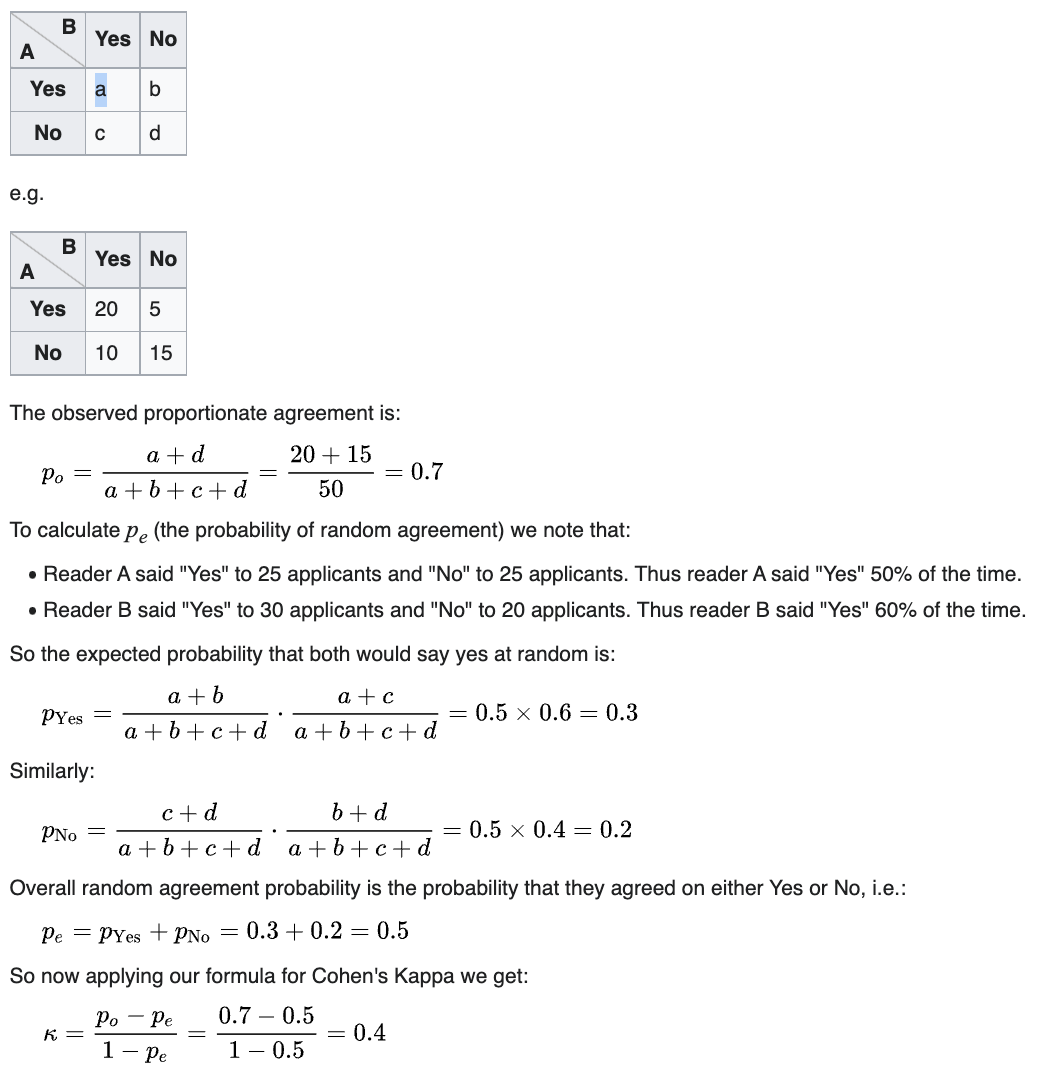

In [2]:
def cross_panel_confusion_matrix(p_GTpos, p_panel_given_pos, p_panel_given_neg):
    tp = p_GTpos * p_panel_given_pos
    fn = p_GTpos * (1-p_panel_given_pos)
    fp = (1-p_GTpos) * p_panel_given_neg
    tn = (1-p_GTpos) * (1-p_panel_given_neg)

    # probability that both raters are positive
    a = p_GTpos * p_panel_given_pos * p_panel_given_pos + (1-p_GTpos) * p_panel_given_neg * p_panel_given_neg
    # probability that first rater is positive and second is negative
    b = p_GTpos * p_panel_given_pos * (1 - p_panel_given_pos) + (1-p_GTpos) * p_panel_given_neg * (1 - p_panel_given_neg)
    c = b
    # probability that both raters are negative
    d = p_GTpos * (1-p_panel_given_pos) * (1-p_panel_given_pos) + (1 - p_GTpos) * (1 - p_panel_given_neg) * (1 - p_panel_given_neg)
    assert math.isclose(a + b + c + d, 1)

    return a, b, c, d

# for testing the function above
# GT = np.array([[0.6,0],[0,0.4]])
# p_panel_given_pos = .8
# p_panel_given_neg = 0.3
# t_noise = np.array([[p_panel_given_pos,1-p_panel_given_pos],[p_panel_given_neg,1-p_panel_given_neg]])
# confusion_matrix = t_noise.T.dot(GT).dot(t_noise)
# print(confusion_matrix)
# [[0.42 0.18]
#  [0.18 0.22]]

vals = cross_panel_confusion_matrix(.6, .8, .3)
assert math.isclose(vals[0], .42)
assert math.isclose(vals[1], .18)
assert math.isclose(vals[2], .18)
assert math.isclose(vals[3], .22)

def kappa(a, b, c, d):
    # how often they agree
    p_0 = (a + d)

    # expected agreement given base rates
    # both say yes
    p_yes = (a+b) * (a+c)
    # both say no
    p_no = (c+d) * (b+d)
    p_e = p_yes + p_no

    kappa = (p_0 - p_e) / (1 - p_e)
    return kappa

assert math.isclose(kappa(.4, .1, .2, .3), .4)

In [3]:
## In the matrices below, the rows are the true values and the columns are the predicted values
## Row 0 is positive, row 1 is negative
## Column 0 is positive, column 1 is negative

def dmi(u):
    "This calculates the dmi of joint distribution u"
    import numpy.linalg as lin
    return abs(lin.det(u))

def smi(u):
    "This calculates the smi of joint distribution u"
    import numpy as np
    m,n = u.shape
    v = 0
    ux = np.empty(m)
    uy = np.empty(n)
    for i in range(m):
        ux[i] = sum(u[i,:])
    for j in range(n):
        uy[j] = sum(u[:,j])

    for i in range(m):
        for j in range(n):
            if u[i][j] != 0:
                v = v + u[i][j] * (np.log2(u[i][j])-np.log2(ux[i]*uy[j]))
    return v        

def cross_entropy(u):
    
    # Calculate TP, FN, FP, TN from confusion matrix
    TP, FN, FP, TN = u[0, 0], u[0, 1], u[1, 0], u[1, 1]
    n_positive = TP + FN
    n_negative = FP + TN
    c_positive = n_positive / (n_positive + n_negative)
    c_negative = n_negative / (n_positive + n_negative)
   
    # Compute probabilities; these will be the calibrated predictions
    p_positive = TP / (TP + FN)     # P(y=1|c=1)
    p_negative = TN / (TN + FP)     # P(y=0|c=0)
    
    # Compute cross entropy
    cross_entropy = - (c_positive * (p_positive * np.log2(p_positive) + (1-p_positive) * np.log2(1-p_positive)) +                  
                        c_negative * (p_negative * np.log2(p_negative) + (1-p_negative) * np.log2(1-p_negative)))
    # print(f"u is {u}\n\tc_positive={c_positive}c_negative={c_negative}\n\tp_positive={p_positive}p_negative={p_negative}\n\tcross entropy is {cross_entropy}")
    return cross_entropy

# def cross_entropy(u):
#     "This calculates the cross entropy of joint distribution u"
#     import numpy as np
#     m,n = u.shape
#     v = 0
#     ux = np.empty(m)
#     uy = np.empty(n)
#     for i in range(m):
#         ux[i] = sum(u[i,:])
#     for j in range(n):
#         uy[j] = sum(u[:,j])
#     print(f"Matrix is {u}")
#     for i in range(m):
#         for j in range(n):
#             if u[i][j] != 0:
#                 print(f"\tadding {u[i][j]} * np.log2({ux[i]}*{uy[j]})")
#                 v = v + u[i][j] * np.log2(ux[i]*uy[j])

#     return -v

def acc(u):
    "This calculates the agreement score of joint distribution u"
    m,n = u.shape
    if m > 2 or n > 2:
        raise ValueError(f"acc scorer only works with hard classifier that gives binary outputs\n {u}")
    return np.trace(u)

def precision(u):
    "This calculates the precision score of joint distribution u"
    m,n = u.shape
    if m > 2 or n > 2:
        raise ValueError(f"precision scorer only works with hard classifier that gives binary outputs\n {u}")
    return u[0][0]/(u[0][0]+u[1][0])

def recall(u):
    "This calculates the recall score of joint distribution u"
    m,n = u.shape
    if m > 2 or n > 2:
        raise ValueError(f"recall scorer only works with hard classifier that gives binary outputs\n {u}")
    return u[0][0]/(u[0][0]+u[0][1])

def f1(u):
    "This calculates the f1 score of joint distribution u"
    m,n = u.shape
    if m > 2 or n > 2:
        raise ValueError(f"f1 scorer only works with hard classifier that gives binary outputs\n {u}")
    p = precision(u)
    r = recall(u)
    return 2*p*r/(p+r)

assert(math.isclose(precision(np.array([[0.8,0.2],[0.1,0.9]])), 0.8888888888888888))
assert(math.isclose(recall(np.array([[0.8,0.2],[0.1,0.9]])), 0.8))

In [4]:
class Scenario:
    def __init__(self, 
                 p_GTpos=.5, 
                 p_raterpos_given_posGT=.8, 
                 p_raterpos_given_negGT=.1, 
                 p_classifierpos_given_posGT=None, 
                 p_classifierpos_given_negGT=None,
                 source_combiner = "majority",
                 scorer = "agreement"
                ):
        self.p_GTpos = p_GTpos
        self.GT = np.array([[self.p_GTpos,0],[0,1-self.p_GTpos]])
        self.p_raterpos_given_posGT = p_raterpos_given_posGT
        self.p_raterpos_given_negGT = p_raterpos_given_negGT
        self.rater_noise = np.array([self.p_raterpos_given_posGT,
                        1-self.p_raterpos_given_posGT,
                        self.p_raterpos_given_negGT,
                        1- self.p_raterpos_given_negGT]).reshape((2, 2))
        
        self.p_classifierpos_given_posGT = p_classifierpos_given_posGT
        self.p_classifierpos_given_negGT = p_classifierpos_given_negGT
        if p_classifierpos_given_posGT and p_classifierpos_given_negGT:
            self.classifier_noise = np.array([self.p_classifierpos_given_posGT,
                            1-self.p_classifierpos_given_posGT,
                            self.p_classifierpos_given_negGT,
                            1- self.p_classifierpos_given_negGT]).reshape((2, 2))
        else:
            self.classifier_noise = None
        self.scorer = scorer
        self.source_combiner = source_combiner
        self.target_combiner = "majority"
        
    def calc_panel_noise_matrix(self, panel_size, combiner="majority"):
        p_panelpos_given_posGT, p_panelpos_given_negGT = 0, 0
        
        ### compute the 2x2 noise matrix for majority of target panel with GT
        # columns are for majority vote yes or no
        # rows are for GT negative or positive
        # cell gives the conditional probability of majority vote outcome, given GT value
        if panel_size == "inf":
            # infinite panel size is just GT, so there is no panel noise; return identity matrix
            return np.array([[1,0],
                             [0,1]])

        elif panel_size == 0:
            # always guess whichever happens more often
            if self.p_GTpos >= 0.5:
                noise_matrix = np.array([[1, 0], 
                                         [1, 0]])
            else:
                noise_matrix = np.array([[0, 1], 
                                         [0, 1]])
            return noise_matrix
        
        else:
            # intermediate panel size

            # add up probabilities of getting exactly i positive labels, for i > panel_size/2
            for i in range((panel_size//2) + 1, panel_size+1):
                p_panelpos_given_posGT += comb(panel_size,i) * (self.p_raterpos_given_posGT ** i) * ((1-self.p_raterpos_given_posGT) ** (panel_size-i))
                p_panelpos_given_negGT += comb(panel_size,i) * (self.p_raterpos_given_negGT ** i) * ((1-self.p_raterpos_given_negGT) ** (panel_size-i))

            if panel_size % 2 == 0:
                # with even panel size, add half the probability of getting exactly half positive
                # we will output pos half the time when the votes are tied
                # note that this will give the same as the conditional probabilities for a panel one smaller
                i = panel_size//2
                p_panelpos_given_posGT += 0.5 * comb(panel_size,i) * (self.p_raterpos_given_posGT ** i) * ((1-self.p_raterpos_given_posGT) ** (panel_size-i))
                p_panelpos_given_negGT += 0.5 * comb(panel_size,i) * (self.p_raterpos_given_negGT ** i) * ((1-self.p_raterpos_given_negGT) ** (panel_size-i))

            majority_noise_matrix = np.array([[p_panelpos_given_posGT,1-p_panelpos_given_posGT],
                                              [p_panelpos_given_negGT,1- p_panelpos_given_negGT]])

            if combiner == "majority":
                return majority_noise_matrix

            elif "ABC" in combiner:
                conditional_probs = np.zeros((2,panel_size+1))
                for i in range(panel_size+1):
                    p_ipos_given_posGT = comb(panel_size,i) * (self.p_raterpos_given_posGT ** i) * ((1-self.p_raterpos_given_posGT) ** (panel_size-i))
                    p_ipos_given_negGT = comb(panel_size,i) * (self.p_raterpos_given_negGT ** i) * ((1-self.p_raterpos_given_negGT) ** (panel_size-i))
                    conditional_probs[0,panel_size-i]=p_ipos_given_posGT
                    conditional_probs[1,panel_size-i]=p_ipos_given_negGT
                assert math.isclose(np.sum(conditional_probs),2)

                if combiner == "ABC_soft":
                    # return a 2 x (panel_size+1) array
                    # columns are for number of raters giving positive labels
                    # rows are for GT negative or positive
                    # cell gives the conditional probability of k positive rater labels, given GT = pos or neg
                    return conditional_probs

                elif combiner == "ABC_hard":
                    # return a 2 x2 array
                    # columns are for predicted positive above/below 50%
                    # rows are for GT negative or positive
                    # cell gives the conditional probability of majority vote outcome, given GT value

                    # for each column, figure out what the ABC output is, pr(next rater = pos | k positive labels)
                    # if that's above 50%, then hard classifier output is pos; else it's neg
                    # then we collapse the all the positive rows

    #                 # V1 So we first turn our conditional probability matrix into a joint distribution of k positive labels and GT.
    #                 joint_dist = conditional_probs.T.dot(self.GT)

                    # V2 We first turn our conditional probaiblity matrix into joint distribution of k positive labels with next rater positive
                    one_rater_noise_matrix = np.array([[p_panelpos_given_posGT, 1-p_panelpos_given_posGT],
                                                       [p_panelpos_given_negGT, 1-p_panelpos_given_negGT]])
                    joint_dist = conditional_probs.T.dot(self.GT).dot(one_rater_noise_matrix)               

                    # V3 We first turn our conditional probability matrix into joint distribution of k positive labels with target panel positive
    #                 joint_dist = conditional_probs.T.dot(self.GT).dot(majority_noise_matrix)                


                    # Look at each row. We have pr(k/s AND GT-value). ABC soft output would be pr(k/s AND GT=1) / [pr(k/s AND GT=1) + pr(k/s AND GT=0)] ]
                    # Then we can just look at ABC soft output and see if it's > 0.5. If so, we output pos
                    collapsed_conditional_probs = np.zeros((2,2))
    #                 print(f"joint_dist panel vs. GT\n{joint_dist}\nconditional_probs panel vs. GT\n{conditional_probs.T}")
                    for joint_pr_row, cond_pr_row in zip(joint_dist, conditional_probs.T):
                        pos_pr, neg_pr = joint_pr_row
                        pr_cond_on_pos, pr_cond_on_neg = cond_pr_row
    #                     print(f"joint_distribution_row {joint_pr_row}\nconditional_row {cond_pr_row}")
                        if pos_pr > neg_pr:
                            # ABC soft output > 0.5, so treat it as positive ABC hard output
                            # row 0 is for GT positive; column 0 is for ABC output positive
                            collapsed_conditional_probs[0,0] += pr_cond_on_pos
                            collapsed_conditional_probs[1,0] += pr_cond_on_neg
                        elif pos_pr < neg_pr:
                            collapsed_conditional_probs[0,1] += pr_cond_on_pos
                            collapsed_conditional_probs[1,1] += pr_cond_on_neg
                        else:
                            # a tie, so treat it as pos output half the time
                            collapsed_conditional_probs[0,0] += 0.5*pr_cond_on_pos
                            collapsed_conditional_probs[1,0] += 0.5*pr_cond_on_neg
                            collapsed_conditional_probs[0,1] += 0.5*pr_cond_on_pos
                            collapsed_conditional_probs[1,1] += 0.5*pr_cond_on_neg


    #                 print(f"returning:\n{collapsed_conditional_probs} for combiner {combiner}\nconditional_probs:\n{conditional_probs}\n")
                    assert math.isclose(np.sum(collapsed_conditional_probs),2)
                    return collapsed_conditional_probs
                
    def inter_panel_reliability(self, panel_size):
        p_panel_given_pos, p_panel_given_neg = self.calc_panel_noise_matrix(panel_size)[0,0], self.calc_panel_noise_matrix(panel_size)[1,0]

        a, b, c, d = cross_panel_confusion_matrix(self.p_GTpos, p_panel_given_pos, p_panel_given_neg)
 
        return kappa(a, b, c, d)

    def score_infinite_items(self, confusion_matrix):
        if self.scorer == 'agreement':
            return acc(confusion_matrix)
        elif self.scorer == 'dmi':
            return dmi(confusion_matrix)
        elif self.scorer == 'smi':
            return smi(confusion_matrix)
        elif self.scorer == 'precision':
            return precision(confusion_matrix)
        elif self.scorer == 'recall':
            return recall(confusion_matrix)
        elif self.scorer == 'f1':
            return f1(confusion_matrix)
        elif self.scorer == 'cross_entropy':
            return cross_entropy(confusion_matrix)
        else:
            print(f"scorer {self.scorer} not implemented")
            raise NotImplementedError
           
    def compute_power_curves(self, source_panel_sizes, target_panel_sizes):
        self.power_curves = {t: PowerCurve(source_panel_sizes, t, self) for t in target_panel_sizes}
        
        
    def get_confusion_matrix(self, source_panel_size, target_panel_size):
        # produce a confusion matrix (joint distribution) of aggregated target panel
        # with either an aggregated source panel (if source_panel_size is specified)
        # OR with the classifier (if source_panel_size is None)
        GT = np.array([[self.p_GTpos,0],[0,1-self.p_GTpos]])
        if target_panel_size=="inf":
            # score against Ground Truth, t=infinity
            # so target_panel_noise is just the identity matrix
            target_panel_noise = np.array([[1, 0], 
                                           [0,1]])
        else:            
            # get noise matrix for target panel output
            target_panel_noise = self.calc_panel_noise_matrix(panel_size=target_panel_size, combiner="majority")

        # use a confusion matrix of a classifier with a target panel
        if source_panel_size is not None:
            # get confusion matrix for source panel output
            classifier_noise = self.calc_panel_noise_matrix(panel_size=source_panel_size, 
                                                            combiner=self.source_combiner)
        else:
            # get noise matrix for classifier
            classifier_noise = self.classifier_noise

#         print(f'classifier_noise: {classifier_noise}')
#         print(f'target_panel_noise: {target_panel_noise}')
        confusion_matrix = classifier_noise.T.dot(self.GT).dot(target_panel_noise)
#         print(f'confusion_matrix: {confusion_matrix}')
        
        return confusion_matrix

    
    def high_kappa(self):
        return self.inter_panel_reliability(1)
        pass
    
    def one_target_rater_is_better(self):
        # TRUE if t=1 and t=inf have the same ordering for classifier and a single rater, 
        # but some other t has the opposite order
        diffs = {t: self.power_curves[t].performance_diffs[1] for t in self.power_curves}
        signs = [np.sign(val) for val in diffs.values()]
        return np.sign(diffs[1]) == np.sign(diffs["inf"]) and len(set(signs)) > 1    

    def first_t_where_classifier_is_worse(self, min_t=0, t_values=None):
        if not t_values:
            t_values = self.power_curves.keys()
        for t in [t for t in t_values if (t=="inf" or t>min_t)]:
            p = self.power_curves[t]
            source_panel_score = p.source_panel_scores[1]
            classifier_score = p.classifier_score
            if p.source_panel_scores[1] > p.classifier_score:
                return t
        return None
        
    def first_t_where_1_rater_is_worse(self, min_t=0, t_values=None):
        if not t_values:
            t_values = self.power_curves.keys()
        for t in [t for t in t_values if (t=="inf" or t>min_t)]:
            p = self.power_curves[t]
            source_panel_score = p.source_panel_scores[1]
            classifier_score = p.classifier_score
            if p.source_panel_scores[1] < p.classifier_score:
                return t
        return None    
                

    def output_table(self, s_values=None, t_values=None):
        rows = []
        if not t_values:
            t_values = self.power_curves.keys()

        for t in t_values:
            p = self.power_curves[t]
            kappa = self.inter_panel_reliability(t)
            classifier_score = p.classifier_score
            ideal_classifier_score = self.score_infinite_items(
                                        self.get_confusion_matrix(source_panel_size="inf",
                                                                  target_panel_size=t))                                
            if not s_values:
                s_values = p.source_panel_sizes
            for s in s_values:
                score = p.source_panel_scores[s]
                performance_diff = p.performance_diffs[s]
                rater_equivalence = p.rater_equiv_value
                rows.append([t, kappa, classifier_score, ideal_classifier_score, s, score, performance_diff, rater_equivalence])
        
        return pd.DataFrame(rows, columns=["t", "kappa", "classif", "max", "s", "s_panel", "c - panel", "r_equiv"])


    def output_classifier_summary_table(self, t_values=None):
        if not t_values:
            t_values = self.power_curves.keys()
        rows = [[t, self.power_curves[t].classifier_score] for t in t_values]
        columns = ["t", f"score"]
        return pd.DataFrame(rows, columns=columns)
    
    def output_cross_entropy_df(self, t_values=None):
        if not t_values:
            t_values = self.power_curves.keys()
        rows = []
        columns = ["Classifier", "Eval Labels", "Calib. Pred. for pos", "Calib. Pred. for neg", "Cross Entropy"]
        def map_t_to_name(t):
            if t == "inf":
                return "Ground Truth"
            elif t == 1:
                return "Single Rater"
            elif t == 3:
                return "3-Rater Panel"                   
            else:
                raise Exception(f"Unknown t value {t}")
        def make_rows(source_panel_size, classifier_name, t_values):
            rows = []
            for t in t_values:
                u = self.get_confusion_matrix(source_panel_size=source_panel_size, target_panel_size=t)
                pred_for_pos = u[0,0]/(u[0,0]+u[0,1])
                # pred_for_pos = f"{u[0,0]}/({u[0,0]}+{u[0,1]})"
                pred_for_neg = u[1,1]/(u[1,0]+u[1,1])
                # pred_for_ng = f"{u[1,1]}/({u[1,0]}+{u[1,1]})"
                rows.append([classifier_name, map_t_to_name(t), pred_for_pos, 1-pred_for_neg, cross_entropy(u)])
            return rows


        rows = make_rows(None, "$c_1$", t_values)
        rows += make_rows(1, "$c_2$", t_values)
 
        return pd.DataFrame(rows, columns=columns)

    def output_t_summary(self, t_values=None, s_values=None):
        if not t_values:
            t_values = self.power_curves.keys()
        res = ""
        for t in t_values:
            res += f"""
t={t}
Inter-panel agreement (kappa) = {self.inter_panel_reliability(t)}
panel-panel joint distribution for t={t}
{self.get_confusion_matrix(source_panel_size=t, target_panel_size=t)}
classifier-panel joint distribution for t={t}
{self.get_confusion_matrix(source_panel_size=None, target_panel_size=t)}
classifier-score for t={t}
{self.power_curves[t].classifier_score}
"""
            for s in s_values:
                res+=f"""{s}_panel_{t}_panel joint distribution
{self.get_confusion_matrix(s, t)}
"""
        return res

    
    def __str__(self):
        return f"""
scorer = {self.scorer}
GT distribution = 
{self.GT}
rater noise conditional on GT =
{self.rater_noise}
classifier noise conditional on GT =
{self.classifier_noise}
rater vs GT joint distribution =
{self.rater_noise.T.dot(self.GT)}
classifier vs GT joint distribution =
{self.classifier_noise.T.dot(self.GT)}
classifier score vs. ground truth =
{self.score_infinite_items(self.get_confusion_matrix(source_panel_size=None, target_panel_size="inf"))}
        """
    
    def figure(self, s_values_to_show=[], include_rater_equivalence=True, filename = None):
        # Create a method for show the power curve
        # if filename is not None, save the figure, else show the figure
        
        from matplotlib import pyplot as plt
        
        # Create several figures for each power_curve
        fig,ax = plt.subplots(1,len(self.power_curves), sharey=True, figsize=(8*len(self.power_curves), 8))
        
        for i, t in enumerate(self.power_curves.keys()):
            power_curve = self.power_curves[t]
            
            # plot the power_score values other than those to show, but make them clear (hidden)

            s_values_to_hide = list(set(power_curve.source_panel_scores.keys()) - set(s_values_to_show))
            source_panel_scores_to_show = [power_curve.source_panel_scores[s] for s in s_values_to_show]
            source_panel_score_to_hide = [power_curve.source_panel_scores[s] for s in s_values_to_hide]

            ax[i].plot(s_values_to_hide, source_panel_score_to_hide, marker = 'o',color = 'r', alpha=0)
            ax[i].plot(s_values_to_show, source_panel_scores_to_show, label = 'source panel scores', marker = 'o',color = 'r', alpha=1)
            ax[i].axhline(power_curve.classifier_score,color='grey',label='classifier score',ls = 'dashed')
            
            ax[i].set_title(f'Power Curve\n Scorer = {self.scorer}, Source Combiner = {self.source_combiner}, Target panel size = {t}')
            
            ax[i].set_xticks(s_values_to_show)
            
            ax[i].legend()

        if include_rater_equivalence:
            # Need all y_values set for all graphs to compute correct y_lim
            for i, t in enumerate(self.power_curves.keys()):
                power_curve = self.power_curves[t]
                ymin, ymax = ax[i].get_ylim()
                ax[i].axvline(power_curve.rater_equiv_value, color='grey',label='rater equivalence',ls = 'dashed',
                              ymax=(power_curve.classifier_score-ymin)/(ymax-ymin))

            
        if filename is not None:
            plt.savefig(filename)
        else:
            plt.show()
           



In [5]:
class PowerCurve:
    def __init__(self, source_panel_sizes, target_panel_size, scenario):
        self.source_panel_sizes = source_panel_sizes
        self.target_panel_size = target_panel_size
        self.scenario = scenario

        # score(self, source_panel_size=None, target_panel_size=None, finite_items=False):

        self.classifier_score = self.scenario.score_infinite_items(
                                    self.scenario.get_confusion_matrix(source_panel_size=None,
                                                                       target_panel_size = self.target_panel_size))
        
        self.source_panel_scores = {size: self.scenario.score_infinite_items(
                                    self.scenario.get_confusion_matrix(source_panel_size = size, 
                                                                       target_panel_size = self.target_panel_size)) 
                                    for size in source_panel_sizes}
        
        self.performance_diffs = {size: self.classifier_score - self.source_panel_scores[size] 
                                   for size in source_panel_sizes}
                
        self.rater_equiv_value = self.rater_equivalence(self.classifier_score, 
                                                        self.source_panel_sizes, 
                                                        self.source_panel_scores)

                
    def rater_equivalence(self, classifier_score, source_panel_sizes, source_panel_scores):
        prev_panel_size = prev_panel_score = None
        # find first panel size where source panel is better
        for cur_panel_size in source_panel_sizes:
            cur_panel_score = source_panel_scores[cur_panel_size]
            if cur_panel_score >= classifier_score:
                if prev_panel_size is None:
                    return 0
                else:
                    # linear interpolation from previous to current panel size
                    # distance toward current panel size is the percentage of difference in scores for the two panels
                    return prev_panel_size + \
                          (cur_panel_size - prev_panel_size) * (classifier_score-prev_panel_score)/(cur_panel_score-prev_panel_score)
            prev_panel_size = cur_panel_size
            prev_panel_score = cur_panel_score

        # source panel was never better than the classifier
#         print(f"source panel never better than classifier; returning max size={max(source_panel_sizes)}")
        return max(source_panel_sizes) if len(source_panel_sizes) > 0 else 0
    
    def __str__(self):
        return f"""{self.scenario}
        target panel size: {self.target_panel_size}
        classifier score: {self.classifier_score}
        source panel scores: {self.source_panel_scores}
        rater equivalence: {self.rater_equiv_value}
        """
    



            

# Generate Info for Primary Counter-Example in the Paper Section titled Cross Entropy: Bigger Panels Not Always The Better

In [6]:
s = Scenario(p_GTpos=.5,
                p_raterpos_given_posGT=.85,
                p_raterpos_given_negGT=.07,
                p_classifierpos_given_posGT=.96,
                p_classifierpos_given_negGT=.2,
                source_combiner="majority",
                scorer="cross_entropy")


             

In [7]:
s.compute_power_curves([1], [1, 3, "inf"])

In [8]:
# s.output_cross_entropy_df()
# convert to latex
print(s.output_cross_entropy_df().to_latex(index=False, float_format="%.6f", escape=False))


\begin{tabular}{llrrr}
\toprule
Classifier &   Eval Labels &  Calib. Pred. for pos &  Calib. Pred. for neg &  Cross Entropy \\
\midrule
     $c_1$ &  Single Rater &              0.715517 &              0.107143 &       0.705982 \\
     $c_1$ & 3-Rater Panel &              0.779727 &              0.058073 &       0.575480 \\
     $c_1$ &  Ground Truth &              0.827586 &              0.047619 &       0.500656 \\
     $c_2$ &  Single Rater &              0.790652 &              0.178333 &       0.705773 \\
     $c_2$ & 3-Rater Panel &              0.868852 &              0.142519 &       0.576897 \\
     $c_2$ &  Ground Truth &              0.923913 &              0.138889 &       0.492504 \\
\bottomrule
\end{tabular}



In [9]:
print(s.output_t_summary(s_values=[1], t_values=[1, 3, "inf"]))


t=1
Inter-panel agreement (kappa) = 0.6123188405797101
panel-panel joint distribution for t=1
[[0.3637 0.0963]
 [0.0963 0.4437]]
classifier-panel joint distribution for t=1
[[0.415 0.165]
 [0.045 0.375]]
classifier-score for t=1
0.7059822670370932
1_panel_1_panel joint distribution
[[0.3637 0.0963]
 [0.0963 0.4437]]

t=3
Inter-panel agreement (kappa) = 0.857935604711521
panel-panel joint distribution for t=3
[[0.44119348 0.03543852]
 [0.03543852 0.48792948]]
classifier-panel joint distribution for t=3
[[0.4522414 0.1277586]
 [0.0243906 0.3956094]]
classifier-score for t=3
0.5754802656472078
1_panel_3_panel joint distribution
[[0.39967174 0.06032826]
 [0.07696026 0.46303974]]

t=inf
Inter-panel agreement (kappa) = 1.0
panel-panel joint distribution for t=inf
[[0.5 0. ]
 [0.  0.5]]
classifier-panel joint distribution for t=inf
[[0.48 0.1 ]
 [0.02 0.4 ]]
classifier-score for t=inf
0.5006562469512351
1_panel_inf_panel joint distribution
[[0.425 0.035]
 [0.075 0.465]]



# Generate Table of Scores with Different Noise Level for Target rater
Tables~\ref{tab:simulate-hard-classifier} and~\ref{tab:simulate-soft-classifier} show results from a simulation. For each of 1,000 items, the ground truth label is set to be positive with probability 0.5 and otherwise negative. 

For table~\ref{tab:simulate-hard-classifier}, a hard classifier generates outputs that reflect the ground truth with some noise: when $g_i$ is positive, $c_h(i)$ is positive with probability 0.8; when $g_i$ is negative, $c_h(i)$ is negative with probability 0.9.

For table~\ref{tab:simulate-soft-classifier}, a soft classifier generates outputs TKTK...

The rows of the tables represent different noise level for human ratings. For each item, three labels are generated as three i.i.d. draws from a Bernoulli distribution defined by the two parameters that define the row: $pr(W_{i,j} = pos | g_i = pos)$ and TKTK. 

In [10]:
# generate Scenarios with no source panel, target panel size 1, and classifier noise parameters and rater noise parameters

def make_scenarios(
    p_classifierpos_given_posGT=.8,
    p_classifierpos_given_negGT=.2,
    p_GTpos=.5,
    scorer="acc",
    base_given_negGT = .51,
    base_given_posGT = .51,
    right_fencepost = .99,
    increment = .01
):
    
    num_increments = max(int((right_fencepost-base_given_posGT)/increment), int((base_given_negGT-1+right_fencepost)/increment))

    return [Scenario(p_GTpos=p_GTpos, 
                p_raterpos_given_posGT=min(base_given_posGT + step*increment, .99), 
                p_raterpos_given_negGT=max(base_given_negGT - step*increment, .01), 
                p_classifierpos_given_posGT=p_classifierpos_given_posGT, 
                p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                scorer = scorer)
            for step in range(num_increments)] 

def get_df_for_scoring_function(scorer):

    scens = make_scenarios(
        p_classifierpos_given_posGT=.99,
        p_classifierpos_given_negGT=.01,
        scorer=scorer,
        base_given_negGT = .3,
        base_given_posGT = .8,
        right_fencepost = .99,
        increment = .01
    )

    for s in scens:
        s.compute_power_curves(source_panel_sizes=[], target_panel_sizes=[1, 3, 5, 7, 9, "inf"])

    def iprs(s):
        return [s.inter_panel_reliability(t) for t in [3, 5, 7, 9]]
    def ipr_colnames():
        return [f"IPR t={t}" for t in [3, 5, 7, 9]]
    
    rows=[[1-s.p_raterpos_given_posGT, s.p_raterpos_given_negGT, s.inter_panel_reliability(1), s.power_curves[1].classifier_score, s.power_curves["inf"].classifier_score] + iprs(s) for s in scens]
    columns = ["noise on pos", "noise on neg", "IRR (kappa)", "agreement", "score vs. gt"] + ipr_colnames()
    df = pd.DataFrame(rows, columns=columns)
    return df

scorer_results = {scorer: get_df_for_scoring_function(scorer) for scorer in ["agreement", "dmi", "smi", "precision", "recall", "f1"]}
main_results = scorer_results["agreement"]

# s.compute_power_curves(source_panel_sizes=[], target_panel_sizes=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, "inf"])
# print(f'scenario with raterpos_given_posGT={s.p_raterpos_given_posGT}, raterpos_given_negGT={s.p_raterpos_given_negGT}, IRR={s.inter_panel_reliability(1)}')
# rows = [[t, s.inter_panel_reliability(t), s.power_curves[t].classifier_score] for t in s.power_curves]
# columns = ["panel size", "Inter-Panel Reliability", "score"]

for scorer in ["precision", "recall", "f1", "dmi", "smi"]:
    main_results[f"{scorer} vs. rater"] = scorer_results[scorer]["agreement"]
    main_results[f"{scorer} vs. gt"] = scorer_results[scorer]["score vs. gt"]
main_results
# for scorer in ["agreement", "dmi", "smi", "precision", "recall", "f1"]:
#     df = get_df_for_scoring_function(scorer)
#     print(f"\n\n{scorer}\n")
#     print(df)

# print rows 0, 7, 11, 14, 21 to latex
selected_rows = main_results.iloc[[0, 7, 11, 14, 21]]
print(selected_rows)
# for tab:jd-scenarios
selected_columns = selected_rows[["noise on pos", "noise on neg", "IRR (kappa)", "agreement", "precision vs. rater", "recall vs. rater", "f1 vs. rater", "dmi vs. rater", "smi vs. rater"]]
selected_columns.columns = ["\\makecell{noise\\\\on pos}", "\\makecell{noise\\\\on neg}", "\\makecell{IRR\\\\(kappa)}", "agreement", "prec", "recall", "f1", "dmi", "smi"]

print(selected_columns.round(2).to_latex(index=False, escape=False))  # index=False to not include the index in the output

# for tab:evaluation-panel-size
selected_columns = selected_rows[["noise on pos", "noise on neg", "IRR (kappa)", "IPR t=3", "IPR t=5", "IPR t=7", "IPR t=9"]]
selected_columns.columns = ["\\makecell{noise\\\\on pos}", "\\makecell{noise\\\\on neg}", "\\makecell{IRR\\\\t=1}", "\\makecell{IPR\\\\t=3}", "\\makecell{IPR\\\\t=5}", "\\makecell{IPR\\\\t=7}", "\\makecell{IPR\\\\t=9}"]
print(selected_columns.round(2).to_latex(index=False, escape=False))  # index=False to not include the index in the output

# rows=[[1-s.p_raterpos_given_posGT, s.p_raterpos_given_negGT, s.inter_panel_reliability(1), s.power_curves[1].classifier_score, s.power_curves["inf"].classifier_score] for s in scens]
# columns = ["error rate on pos", "error rate on neg", "kappa", "score vs. 1", "score vs. gt"]
# pd.DataFrame(rows, columns=columns)


    noise on pos  noise on neg  IRR (kappa)  agreement  score vs. gt  \
0           0.20          0.30     0.252525     0.7450          0.99   
7           0.13          0.23     0.413737     0.8136          0.99   
11          0.09          0.19     0.523636     0.8528          0.99   
14          0.06          0.16     0.614545     0.8822          0.99   
21          0.01          0.09     0.815217     0.9410          0.99   

     IPR t=3   IPR t=5   IPR t=7   IPR t=9  precision vs. rater  \
0   0.468274  0.613627  0.712766  0.782146             0.722727   
7   0.676545  0.810861  0.884065  0.926522             0.785091   
11  0.782970  0.891237  0.941999  0.967891             0.820727   
14  0.851172  0.934509  0.969175  0.984982             0.847455   
21  0.954741  0.987378  0.996333  0.998910             0.908333   

    precision vs. gt  recall vs. rater  recall vs. gt  f1 vs. rater  \
0               0.99            0.7950           0.99      0.757143   
7               0.99  

In [11]:
# generate Scenarios with no source panel, varied target panel sizes, and classifier noise parameters and rater noise parameters

def make_scenarios(
    p_classifierpos_given_posGT=.8,
    p_classifierpos_given_negGT=.2,
    p_GTpos=.5,
    scorer="acc",
    base_given_negGT = .51,
    base_given_posGT = .51,
    right_fencepost = .99,
    increment = .01
):
    
    num_increments = max(int((right_fencepost-base_given_posGT)/increment), int((base_given_negGT-1+right_fencepost)/increment))

    return [Scenario(p_GTpos=p_GTpos, 
                p_raterpos_given_posGT=min(base_given_posGT + step*increment, .99), 
                p_raterpos_given_negGT=max(base_given_negGT - step*increment, .01), 
                p_classifierpos_given_posGT=p_classifierpos_given_posGT, 
                p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                scorer = scorer)
            for step in range(num_increments)] 

scens = make_scenarios(
    p_classifierpos_given_posGT=.99,
    p_classifierpos_given_negGT=.01,
    scorer="agreement",
    base_given_negGT = .3,
    base_given_posGT = .8,
    right_fencepost = .99,
    increment = .01
)

for s in [scens[0], scens[7], scens[11]]:
    s.compute_power_curves(source_panel_sizes=[], target_panel_sizes=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, "inf"])
    print(f'scenario with raterpos_given_posGT={s.p_raterpos_given_posGT}, raterpos_given_negGT={s.p_raterpos_given_negGT}, IRR={s.inter_panel_reliability(1)}')
    rows = [[t, s.inter_panel_reliability(t), s.power_curves[t].classifier_score] for t in s.power_curves]
    columns = ["panel size", "Inter-Panel Reliability", "score"]
    df = pd.DataFrame(rows, columns=columns)
    print(df.to_latex(index=False))  # index=False to not include the index in the output
    # print(pd.DataFrame(rows, columns=columns))

# rows=[[1-s.p_raterpos_given_posGT, s.p_raterpos_given_negGT, s.inter_panel_reliability(1), s.power_curves[1].classifier_score, s.power_curves["inf"].classifier_score] for s in scens]
# columns = ["error rate on pos", "error rate on neg", "kappa", "score vs. 1", "score vs. gt"]
# pd.DataFrame(rows, columns=columns)


scenario with raterpos_given_posGT=0.8, raterpos_given_negGT=0.3, IRR=0.25252525252525254
\begin{tabular}{lrr}
\toprule
panel size &  Inter-Panel Reliability &    score \\
\midrule
         1 &                 0.252525 & 0.745000 \\
         3 &                 0.468274 & 0.833200 \\
         5 &                 0.613627 & 0.881710 \\
         7 &                 0.712766 & 0.911904 \\
         9 &                 0.782146 & 0.931989 \\
        11 &                 0.832007 & 0.945959 \\
        13 &                 0.868719 & 0.956004 \\
        15 &                 0.896317 & 0.963416 \\
        17 &                 0.917424 & 0.968999 \\
        19 &                 0.933796 & 0.973275 \\
       inf &                 1.000000 & 0.990000 \\
\bottomrule
\end{tabular}

scenario with raterpos_given_posGT=0.8700000000000001, raterpos_given_negGT=0.22999999999999998, IRR=0.41373737373737385
\begin{tabular}{lrr}
\toprule
panel size &  Inter-Panel Reliability &    score \\
\midrule
        

## Plot classifier noise vs. score difference between classifier and s=1 source panel, for t=1, 3, inf

In [29]:
# Plot y-axis as difference in score between classifier and s=1 panel
def non_monotonicity_figure(scenarios, save_to_file=None):
        
    noise_values = [scen.p_classifierpos_given_posGT for scen in scenarios]
        
    for scen in scenarios:
        scen.compute_power_curves([1], [1, 3, "inf"])
        
    def get_values(t):
        return [scen.power_curves[t].performance_diffs[1] for scen in scenarios]

    def first_crossing(t):
        crossings = [scen for scen in scenarios if scen.power_curves[t].performance_diffs[1]>=0]
        if len(crossings) > 0:
            return crossings[0].p_classifierpos_given_posGT
        else:
            return None
        
    
    # Create a figure and axis object
    fig, ax = plt.subplots()
    
    # Plot each line on the same axis
    ax.plot(noise_values, get_values(1), label='score1', color="orange")
    ax.plot(noise_values, get_values(3), label='score3', color="green")
    ax.plot(noise_values, get_values("inf"), label='scoreG', color="blue")
    ax.axhline(y=0, color="black", label='classifierA=ClassifierB')
    
    x,y = ax.get_ylim()
    ymax_as_percent = (0-x)/(y-x)

    crossing1, crossing3, crossing_inf = first_crossing(1), first_crossing(3), first_crossing("inf")
    if crossing1:
        ax.axvline(x=crossing1, ymax=ymax_as_percent, color="orange", linestyle="dashed")
    if crossing3:
        ax.axvline(x=crossing3, ymax=ymax_as_percent, color="green", linestyle="dashed")
    if crossing_inf:
        ax.axvline(x=crossing_inf, ymax=ymax_as_percent, color="blue", linestyle="dashed")



    # Set the axis labels
    ax.set_xlabel('classifierpos_given_posGT')
    ax.set_ylabel(f'{scenarios[0].scorer} difference between classifier and s=1 source panel')

    # Add a legend
    ax.legend()

    # Save the figure in tikz format
    if save_to_file:
        tikzplotlib.save(save_to_file)

    # Show the plot
    plt.show()




In [30]:
# Plot y-axis as rater equivalence value
        
def rater_equiv_inversion_figure(scenarios):
        
    noise_values = [scen.p_classifierpos_given_posGT for scen in scenarios]
    
    def get_rater_equiv_scores(t):
        return [scen.power_curves[t].rater_equiv_value for scen in scenarios]
        
    
    # Create a figure and axis object
    fig, ax = plt.subplots()
    
    # Plot each line on the same axis
    ax.plot(noise_values, get_rater_equiv_scores(1), label='score1', color="orange")
    ax.plot(noise_values, get_rater_equiv_scores(3), label='score3', color="green")
    ax.plot(noise_values, get_rater_equiv_scores("inf"), label='scoreG', color="blue")
    

    # Set the axis labels
    ax.set_xlabel('classifierpos_given_posGT')
    ax.set_ylabel(f'{scenarios[0].scorer} rater equivalence of the classifier')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


In [31]:
# Plot y-axis as scores (classifier and s=1 panel as separate lines)
def alt_non_monotonicity_figure(scenarios):
        
    noise_values = [scen.p_classifierpos_given_posGT for scen in scenarios]
        
    for scen in scenarios:
        scen.compute_power_curves([1], [1, 3, "inf"])
        
    def get_classifier_scores(t):
        return [scen.power_curves[t].classifier_score for scen in scenarios]
        
    def get_source_panel_scores(t):
        return [scen.power_curves[t].source_panel_scores[1] for scen in scenarios]

    def first_crossing(t):
        crossings = [scen for scen in scenarios if scen.power_curves[t].performance_diffs[1]>=0]
        if len(crossings) > 0:
            return crossings[0].p_classifierpos_given_posGT
        else:
            return None

    
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot each line on the same axis
    ax.plot(noise_values, get_classifier_scores(1), label='C vs. t=1', color="orange")
    ax.plot(noise_values, get_classifier_scores(3), label='C vs. t=3', color="green")
    ax.plot(noise_values, get_classifier_scores("inf"), label='C vs. t=inf', color="blue")
    
    ax.plot(noise_values, get_source_panel_scores(1), label='s=1 vs. t=1', color="orange", linestyle="dashed")
    ax.plot(noise_values, get_source_panel_scores(3), label='s=1 vs. t=3', color="green", linestyle="dashed")
    ax.plot(noise_values, get_source_panel_scores("inf"), label='s=1 vs. t=inf', color="blue", linestyle="dashed")
    

    crossing1, crossing3, crossing_inf = first_crossing(1), first_crossing(3), first_crossing("inf")
    if crossing1:
        ax.axvline(x=crossing1, ymax=0.1, color="orange", linestyle="dashed")
    if crossing3:
        ax.axvline(x=crossing3, ymax=0.1, color="green", linestyle="dashed")
    if crossing_inf:
        ax.axvline(x=crossing_inf, ymax=0.1, color="blue", linestyle="dashed")


    # Set the axis labels
    ax.set_xlabel('classifierpos_given_posGT')
    ax.set_ylabel(f'score ({scenarios[0].scorer}) ')

    # Add a legend
    ax.legend(loc='upper left')

    # Show the plot
    plt.show()


In [32]:
def make_scenarios(
    p_raterpos_given_posGT=.7,
    p_raterpos_given_negGT=.05, 
    p_classifierpos_given_negGT=.2,
    p_GTpos=.5,
    source_combiner="ABC_soft",
    scorer="acc",
    base = .51,
    right_fencepost = .99,
    increment = .01
):

    return [Scenario(p_GTpos=p_GTpos, 
                p_raterpos_given_posGT=p_raterpos_given_posGT, 
                p_raterpos_given_negGT=p_raterpos_given_negGT, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                source_combiner = source_combiner,
                scorer = scorer)
            for step in range(int((right_fencepost-base)/increment))] 

In [33]:
def inverted(scen, strict=False, inverted_rater_equiv=False):
        
    if inverted_rater_equiv:
        # compute based on rater_equivalence values
        # if strict, check whether integer equivalence values are separated
        # also check whether
        v_inf = scen.power_curves["inf"].rater_equiv_value
        v_1 = scen.power_curves[1].rater_equiv_value
        v_3 = scen.power_curves[3].rater_equiv_value
        if v_inf > v_1 > v_3:
            if strict:
                return int(v_1)==1 and int(v_3)==0
            else:
                return True
        elif v_inf < v_1 < v_3:
            if strict:
                return int(v_1)==0 and int(v_3)==1   
            else:
                return True
        else:
            return False
    else:
        # compute based on performance diff between s=1 panel and classifier
        # if strict, check whether rater equivalence is on opposite sides of 1 for t=1,inf vs. t=3
        v_inf = scen.power_curves["inf"].performance_diffs[1]
        v_1 = scen.power_curves[1].performance_diffs[1]
        v_3 = scen.power_curves[3].performance_diffs[1]
        if v_inf > v_1 > v_3:
            if strict:
                return v_1 > 0 and v_3 < 0
            else:
                return True
        elif v_inf < v_1 < v_3:
            if strict:
                return v_1 < 0 and v_3 > 0       
            else:
                return True
        else:
            return False


In [17]:
# find scenarios for p_classifierpos_given_posGT where score diff ordered as t_inf > t_1 > t_3 or reverse
# if strict, also required score diff for t_1 > 1 and score diff for t_3 < 1 (or reverse if t_inf is smallest)

def get_inverted_scenarios(
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.05, 
        p_classifierpos_given_negGT=.2,
        p_GTpos=.5,
        source_combiner="ABC_soft",
        scorer="agreement",
        increment = .01,
        strict=False,
        inverted_rater_equiv=False
):
    
    scenarios = make_scenarios(    
        p_raterpos_given_posGT=p_raterpos_given_posGT,
        p_raterpos_given_negGT=p_raterpos_given_negGT, 
        p_classifierpos_given_negGT=p_classifierpos_given_negGT,
        p_GTpos=p_GTpos,
        source_combiner=source_combiner,
        scorer=scorer,
        base = .51,
        right_fencepost = .99,
        increment = increment)

    if inverted_rater_equiv:
        for scen in scenarios:
            scen.compute_power_curves([0, 1, 3, 5], [1, 3, "inf"])
    else:
        for scen in scenarios:
            scen.compute_power_curves([1], [1, 3, "inf"])
        

    return [scen for scen in scenarios if inverted(scen, strict=strict, inverted_rater_equiv=inverted_rater_equiv)]


In [18]:
def inverted(scen, strict=False, inverted_rater_equiv=False):
        
    if inverted_rater_equiv:
        # compute based on rater_equivalence values
        # if strict, check whether integer equivalence values are separated
        # also check whether
        v_inf = scen.power_curves["inf"].rater_equiv_value
        v_1 = scen.power_curves[1].rater_equiv_value
        v_3 = scen.power_curves[3].rater_equiv_value
        if v_inf > v_1 > v_3:
            if strict:
                return int(v_inf) == int(v_1) and int(v_inf) != int(v_3)
            else:
                return True
        elif v_inf < v_1 < v_3:
            if strict:
                return int(v_inf) == int(v_1) and int(v_inf) != int(v_3)   
            else:
                return True
        else:
            return False
    else:
        # compute based on performance diff between s=1 panel and classifier
        # if strict, check whether rater equivalence is on opposite sides of 1 for t=1,inf vs. t=3
        v_inf = scen.power_curves["inf"].performance_diffs[1]
        v_1 = scen.power_curves[1].performance_diffs[1]
        v_3 = scen.power_curves[3].performance_diffs[1]
        if v_inf > v_1 > v_3:
            if strict:
                return v_1 > 0 and v_3 < 0
            else:
                return True
        elif v_inf < v_1 < v_3:
            if strict:
                return v_1 < 0 and v_3 > 0       
            else:
                return True
        else:
            return False


In [19]:
# find range of vals for p_classifierpos_given_posGT where score diff ordered as t_inf > t_1 > t_3 or reverse
# if strict, also required score diff for t_1 > 1 and score diff for t_3 < 1 (or reverse if t_inf is smallest)
def get_inversion_range(
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.05, 
        p_classifierpos_given_negGT=.2,
        p_GTpos=.5,
        source_combiner="ABC_soft",
        scorer="agreement",
        increment = .01,
        strict=False
):

    inversions = get_inverted_scenarios(    
        p_raterpos_given_posGT=p_raterpos_given_posGT,
        p_raterpos_given_negGT=p_raterpos_given_negGT, 
        p_classifierpos_given_negGT=p_classifierpos_given_negGT,
        p_GTpos=p_GTpos,
        source_combiner=source_combiner,
        scorer=scorer,
        increment = increment,
        strict=strict)
    
    if len(inversions) > 1:
        return sorted([inversions[0].p_classifierpos_given_posGT, inversions[-1].p_classifierpos_given_posGT])
    else:
        return [None, None]

In [35]:
def make_inverted_range_figure(
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.05, 
        p_classifierpos_given_negGT=.2,
        p_GTpos=.5,
        source_combiner="ABC_soft",
        scorer="acc",
        strict=False,
        increment=.01,
        inverted_rater_equiv=False,
        save_to_file=None
):

    inversions = get_inverted_scenarios(    
        p_raterpos_given_posGT=p_raterpos_given_posGT,
        p_raterpos_given_negGT=p_raterpos_given_negGT, 
        p_classifierpos_given_negGT=p_classifierpos_given_negGT,
        p_GTpos=p_GTpos,
        source_combiner=source_combiner,
        scorer=scorer,
        increment=increment,
        strict=strict,
        inverted_rater_equiv=inverted_rater_equiv)

    if len(inversions) > 0:
        if inverted_rater_equiv:
            rater_equiv_inversion_figure(inversions)
        else:
            non_monotonicity_figure(inversions, save_to_file=save_to_file)
    else:
        print("No values of p_classifierpos_given_posGT with bad ordering")
    

## Grid search on parameter values

In [36]:
def grid_search(p_classifierpos_given_negGT=.1, source_combiner="ABC_soft", scorer="agreement", increment=.01, inverted_rater_equiv=False):
    rows = []
    for p_raterpos_given_posGT in range(75, 99, 2):
        print("-")
        for p_raterpos_given_negGT in range(1, 25, 2):
            print(".", end="")
            for p_GTpos in range(2, 52, 2):
                loose_inversions = get_inverted_scenarios(
                    p_raterpos_given_posGT=p_raterpos_given_posGT/100,
                    p_raterpos_given_negGT=p_raterpos_given_negGT/100, 
                    p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                    p_GTpos=p_GTpos/100,
                    source_combiner=source_combiner,
                    scorer=scorer,
                    increment = increment,
                    strict = False,
                    inverted_rater_equiv=inverted_rater_equiv
                )
                if len(loose_inversions)>0:
                    left = loose_inversions[0].p_classifierpos_given_posGT
                    right = loose_inversions[-1].p_classifierpos_given_posGT
                    rater_equiv_vs_inf = loose_inversions[0].power_curves["inf"].rater_equiv_value
                    kappa = loose_inversions[0].inter_panel_reliability(1)
 
                    strict_inversions = [s for s in loose_inversions if inverted(s, strict=True, inverted_rater_equiv=inverted_rater_equiv)]
                    if len(strict_inversions)>0:
                        strict_left = strict_inversions[0].p_classifierpos_given_posGT
                        strict_right = strict_inversions[-1].p_classifierpos_given_posGT
                    else:
                        strict_left, strict_right = None, None

                    rows.append([p_GTpos/100, p_raterpos_given_posGT/100, p_raterpos_given_negGT/100, p_classifierpos_given_negGT, left, right, strict_left, strict_right, rater_equiv_vs_inf, kappa])
    return pd.DataFrame(rows, columns=["p_GTpos", "p_raterpos_given_posGT", "p_raterpos_given_negGT", "p_classifierpos_given_negGT", "min p_classifierpos_given_posGT", "max p_classifierpos_given_posGT", "strict min", "strict max", "rater_equiv_vs_inf", "kappa", ])


In [37]:
def show_row(row, source_combiner="ABC_soft", scorer="smi", increment=.0001, inverted_rater_equiv=False, save_to_file=None):
    # whole range
    scenarios = make_scenarios(
        p_GTpos=row.loc["p_GTpos"], 
        p_raterpos_given_posGT=row.loc["p_raterpos_given_posGT"], 
        p_raterpos_given_negGT=row.loc["p_raterpos_given_negGT"], 
        p_classifierpos_given_negGT=row.loc["p_classifierpos_given_negGT"],
        source_combiner = source_combiner,
        scorer = scorer,
        increment=increment,
        base = .51,
        right_fencepost = .99)
    
    if inverted_rater_equiv:
        for scen in scenarios:
            scen.compute_power_curves([0, 1, 3, 5], [1, 3, "inf"])
        rater_equiv_inversion_figure(scenarios)
    else:
        for scen in scenarios:
            scen.compute_power_curves([1], [1, 3, "inf"])
        non_monotonicity_figure(scenarios)
    
    # inversion zone
    make_inverted_range_figure(
        p_GTpos=row.loc["p_GTpos"], 
        p_raterpos_given_posGT=row.loc["p_raterpos_given_posGT"], 
        p_raterpos_given_negGT=row.loc["p_raterpos_given_negGT"], 
        p_classifierpos_given_negGT=row.loc["p_classifierpos_given_negGT"],
        source_combiner = source_combiner,
        scorer = scorer,
        increment=increment,
        strict=False,
        inverted_rater_equiv=inverted_rater_equiv,
        save_to_file=save_to_file)


    # strict inversion zone
    make_inverted_range_figure(
        p_GTpos=row.loc["p_GTpos"], 
        p_raterpos_given_posGT=row.loc["p_raterpos_given_posGT"], 
        p_raterpos_given_negGT=row.loc["p_raterpos_given_negGT"], 
        p_classifierpos_given_negGT=row.loc["p_classifierpos_given_negGT"],
        source_combiner = source_combiner,
        scorer = scorer,
        increment=increment,
        strict=True,
        inverted_rater_equiv=inverted_rater_equiv)
    
    return scenarios


With smi scorer, we have some cases where rater equivalence is on the same side of 1 for t=1 and t=inf, but on other side with t=3.

In [23]:
df1 = grid_search(p_classifierpos_given_negGT=.2, source_combiner="ABC_soft", scorer="smi", increment=.01, inverted_rater_equiv=False)

-
............-
............-
............-
............-
............-
............-
............-
............-
............-
............-
............-
............

In [24]:
df1.loc[df1['strict min'].notnull() & (df1['p_GTpos'].between(.4999, .5001))]

,p_GTpos,p_raterpos_given_posGT,p_raterpos_given_negGT,p_classifierpos_given_negGT,min p_classifierpos_given_posGT,max p_classifierpos_given_posGT,strict min,strict max,rater_equiv_vs_inf,kappa
100,0.5,0.75,0.09,0.2,0.86,0.87,0.86,0.86,0,0.447044
278,0.5,0.77,0.13,0.2,0.84,0.84,0.84,0.84,0,0.413737
589,0.5,0.81,0.23,0.2,0.78,0.78,0.78,0.78,0,0.336939
751,0.5,0.85,0.07,0.2,0.96,0.96,0.96,0.96,0,0.612319


### Counter-example with p_GTpos == 0.5 and kappa above 0.6
But very small range where inversion happens

In [25]:
row = df1.iloc[751]

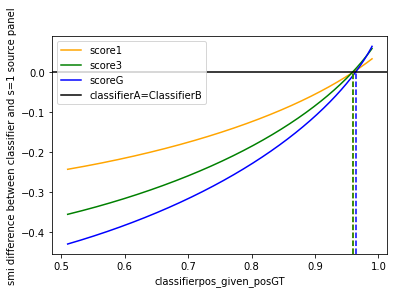

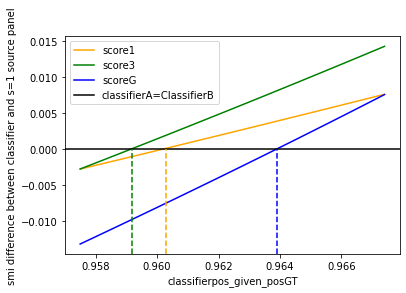

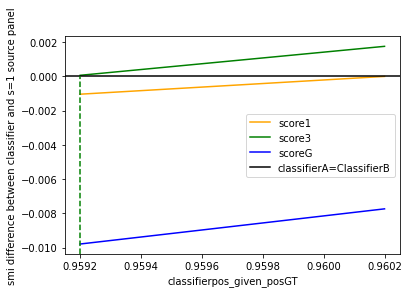

In [38]:
scenarios = show_row(row, save_to_file="cross_entropy_inversion.tikz")

In [ ]:
row

In [ ]:
scen = Scenario(p_GTpos=row["p_GTpos"], 
                p_raterpos_given_posGT=row["p_raterpos_given_posGT"], 
                p_raterpos_given_negGT=row["p_raterpos_given_negGT"], 
                p_classifierpos_given_posGT=.96, 
                p_classifierpos_given_negGT=row["p_classifierpos_given_negGT"],
                source_combiner="ABC_soft", 
                scorer="smi")
scen.compute_power_curves([0, 1, 3], [1, 3, "inf"] )
print(scen.power_curves[1])

In [ ]:
scen.output_table(s_values=[1], t_values=[1, 3, "inf"])

#### With slightly bigger range where inverted
But imbalanced

In [ ]:
df1['diff'] = df1['max p_classifierpos_given_posGT'] - df1['min p_classifierpos_given_posGT']

In [ ]:
df1.loc[df1['strict min'].notnull() & (df1['diff'] > .03)]

In [ ]:
row = df1.iloc[23]

In [ ]:
scenarios = show_row(row)

In [ ]:
row

In [ ]:
scen = Scenario(p_GTpos=row["p_GTpos"], 
                p_raterpos_given_posGT=row["p_raterpos_given_posGT"], 
                p_raterpos_given_negGT=row["p_raterpos_given_negGT"], 
                p_classifierpos_given_posGT=.975, 
                p_classifierpos_given_negGT=row["p_classifierpos_given_negGT"],
                source_combiner="ABC_soft", 
                scorer="smi")
scen.compute_power_curves([0, 1, 3], [1, 3, "inf"] )
print(scen.power_curves[1])

In [ ]:
scen.output_table(s_values=[1], t_values=[1, 3, "inf"])

# Ignore everything after this

In [ ]:
def extended_trace(u):
    sum_of_larger_values = 0

    # Iterate over the rows of the array
    for row in u:
        sum_of_larger_values += max(row)
    
    return(sum_of_larger_values)

In [ ]:
# tests for extended_trace
assert math.isclose(
    (extended_trace([[.6, .1],
                     [.1, .2]])), .8)
assert math.isclose(extended_trace([[.6, .1],
                        [.05, .1], 
                        [.05, .1]]), .8)
assert math.isclose(extended_trace([[.55, .01],
                        [.05, .09],
                        [.05, .1], 
                        [.05, .1]]), .84)

In [ ]:
def acc( u ):
    "This calculates the agreement score of joint distribution u"
    m,n = u.shape
    if n > 2:
        raise ValueError(f"acc scorer as defined only works binary labels\n {u}")
    return extended_trace(u)

In [ ]:
def acc( u ):
    "This calculates the agreement score of joint distribution u"
    m,n = u.shape
    if m > 2 or n > 2:
        raise ValueError(f"acc scorer only works with hard classifier that gives binary outputs\n {u}")
    return np.trace(u)

With agreement scorer, there is no range where we get a reversal with both t=1 and t=inf on one side and t=3 on the other side of rater-equiv==1

But we do get ones where the rater equivalences have the inversion we're looking for, even strict ones, with different integer rater equivalences.

In [ ]:
def get_scenarios(row, source_combiner="ABC_soft", scorer="smi", increment=.0001, inverted_rater_equiv=False):
    # whole range
    scenarios = make_scenarios(
        p_GTpos=row.loc["p_GTpos"], 
        p_raterpos_given_posGT=row.loc["p_raterpos_given_posGT"], 
        p_raterpos_given_negGT=row.loc["p_raterpos_given_negGT"], 
        p_classifierpos_given_negGT=row.loc["p_classifierpos_given_negGT"],
        source_combiner = source_combiner,
        scorer = scorer,
        increment=increment,
        base = .51,
        right_fencepost = .99)
    
    if inverted_rater_equiv:
        for scen in scenarios:
            scen.compute_power_curves([0, 1, 3, 5], [1, 3, "inf"])
        rater_equiv_inversion_figure(scenarios)
    else:
        for scen in scenarios:
            scen.compute_power_curves([1], [1, 3, "inf"])
        non_monotonicity_figure(scenarios)
    return(scenarios)
    

#### Explaining the Shapes of the Curves and the Reason for Crossings
Imagine varying both of the classifier's error rates, going from all noise to perfect classifier.
- With all noise
    - classifier score against any t will be 0
    - score differential will be negative of source panel score against that t
    - with higher t, that source panel score will be higher
    - therefore we have ordering of score differentials t=1 > t=3 > t=inf
- With no classifier noise
    - classifier score against t will be the noise of the t-panel
    - with higher t, classifier improves more than the source panel does (because source panel has some noise)
    - therefore we have ordering of score differentials t=inf > t=3 > t=1

## Building up intuitions for agreement scorer

#### Explaining Why we Don't Get Strict Inversions

To build up intuitions, for a scenario print out:
- Joint distributions of Classifier-GT and source-panel-GT, for s=1 (2)
- Gt | target panel noise matrix for t=1, 3, inf (3)
- Joint distrubutions of Cl,target-panel and source,target-panel (2x3 = 6)

In [ ]:
def show_matrices(scen):
    print(f"""
classifier vs GT joint distribution =
{scen.classifier_noise.T.dot(scen.GT)}
rater vs GT joint distribution =
{scen.rater_noise.T.dot(scen.GT)}
GT|target-panel noise matrices:
    t=1
{scen.calc_panel_noise_matrix(panel_size=1, combiner="majority").T} 
    t=3
{scen.calc_panel_noise_matrix(panel_size=3, combiner="majority").T}
    t=inf
{scen.calc_panel_noise_matrix(panel_size="inf", combiner="majority").T}
""")
    print(f"""
--- Classifier-panel joint distributions
t=1
{scen.get_confusion_matrix(source_panel_size=None, target_panel_size=1)}
t=3
{scen.get_confusion_matrix(source_panel_size=None, target_panel_size=3)}
t=inf
{scen.get_confusion_matrix(source_panel_size=None, target_panel_size="inf")}
--- rater-panel joint distributions
t=1
{scen.get_confusion_matrix(source_panel_size=1, target_panel_size=1)}
t=3
{scen.get_confusion_matrix(source_panel_size=1, target_panel_size=3)}
t=inf
{scen.get_confusion_matrix(source_panel_size=1, target_panel_size="inf")}
        -----next scenario------
""")


In [ ]:
def slope_and_intercept(x1, y1, x2, y2, which_intercept="x"):
    slope = (y2-y1) / (x2-x1)
    x_intercept = x1 - y1/slope
    y_intercept = y1 - slope*x1
    
    if which_intercept=="x":
        return slope, x_intercept
    else:
        return slope, y_intercept

In [ ]:
def slopes_and_intercepts(p_raterpos_given_posGT, p_raterpos_given_negGT, p_classifierpos_given_negGT, p_GTpos=.5, source_combiner="ABC_soft", scorer="smi", which_intercept="x"):
    # get score_diff at .51 and .99; compute slope and intercept; with agreement scorer it's linear...
    scen1 = Scenario(p_GTpos=p_GTpos, 
                p_raterpos_given_posGT=p_raterpos_given_posGT, 
                p_raterpos_given_negGT=p_raterpos_given_negGT, 
                p_classifierpos_given_posGT=.51, 
                p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                source_combiner = source_combiner,
                scorer = scorer)
    
    scen2 = Scenario(p_GTpos=p_GTpos, 
                p_raterpos_given_posGT=p_raterpos_given_posGT, 
                p_raterpos_given_negGT=p_raterpos_given_negGT, 
                p_classifierpos_given_posGT=.99, 
                p_classifierpos_given_negGT=p_classifierpos_given_negGT,
                source_combiner = "ABC_soft",
                scorer = "agreement")
    
    scen1.compute_power_curves([1], [1, 3, "inf"])
    scen2.compute_power_curves([1], [1, 3, "inf"])
    
    slopes = []
    intercepts = []
    for t in [1, 3, "inf"]:
        y1 = scen1.power_curves[t].performance_diffs[1]
        y2 = scen2.power_curves[t].performance_diffs[1]
        slope, intercept = slope_and_intercept(.51, y1, .99, y2, which_intercept)
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts
        

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.7, 
                      p_raterpos_given_negGT=.05, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.75, 
                      p_raterpos_given_negGT=.05, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.8, 
                      p_raterpos_given_negGT=.05, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.85, 
                      p_raterpos_given_negGT=.05, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.9, 
                      p_raterpos_given_negGT=.25, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

In [ ]:
slopes_and_intercepts(p_raterpos_given_posGT=.99, 
                      p_raterpos_given_negGT=.49, 
                      p_classifierpos_given_negGT=.2, 
                      p_GTpos=.5)

### Grid Search to find a spot where x-intercepts are in right order
Can't find any!

In [ ]:
for p_raterpos_given_posGT in range(51, 99):
    for p_raterpos_given_negGT in range(1, 49):
        for p_GTpos in range(50, 99):
            slopes, intercepts = slopes_and_intercepts(p_raterpos_given_posGT=p_raterpos_given_posGT/100, 
                                                       p_raterpos_given_negGT=p_raterpos_given_negGT/100, 
                                                       p_classifierpos_given_negGT=.2, 
                                                       p_GTpos=p_GTpos/100)
            i1, i3, i_inf = intercepts
            min_diff = .0000000000001
            if (i_inf + min_diff < i1 < i3 - min_diff):
                print(f"intercepts={intercepts} params={p_raterpos_given_posGT, p_raterpos_given_negGT, .2, p_GTpos}")
            

In [ ]:
## use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.05, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

### p_GTpos=.5, p_raterpos_given_posGT=.81, p_raterpos_given_negGT=.1
Reversal around .87, but no reversal of survey equivalence

In [ ]:
base = .88
increment = .001
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)

for scen in [scenarios[0], scenarios[-1]]:
    show_matrices(scen)
#     scen.compute_power_curves([1], [1, 3, "inf"])
# #     print(f"""
# # panel_noise_matrix: {scen.calc_panel_noise_matrix(1)}:
# # acc: {acc(scen.calc_panel_noise_matrix(1))}
# # """)
#     print(f"""{scen.output_t_summary(s_values = [1])}""")


In [ ]:
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.6, 
                p_raterpos_given_negGT=.01, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
## use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .84
increment = .001
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(100)]

non_monotonicity_figure(scenarios)    

##### Try to get survey equivalence above or below 1

Note that if rater_posGT and rater_negGT are symmetric, the lines all cross at exactly the same point, so there's no region where we have a problem. 

Or maybe it's when rater_negGT == classifier_neg_givenGT that the lines all cross at the same point?

In [ ]:
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)    


In [ ]:
base = .84
increment = .0005
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.9, 
                p_raterpos_given_negGT=.15, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "ABC_soft",
                scorer = "agreement")
            for step in range(49)]

non_monotonicity_figure(scenarios)    


# SMI random explorations 
p_GTpos=.5, p_raterpos_given_posGT=.81, p_raterpos_given_negGT=.1

In [ ]:
## use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(49)]

non_monotonicity_figure(scenarios)    


In [ ]:
## use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .8
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(19)]

non_monotonicity_figure(scenarios)    

In [ ]:
## use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .9
increment = .001
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(19)]

non_monotonicity_figure(scenarios)    

### p_GTpos=.5, p_raterpos_given_posGT=.9, p_raterpos_given_negGT=.1,

Also get reversal, so a region where orange closer to blue. But no region with rater equivalence on opposite sides of 1.

In [ ]:
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.9, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
base = .95
increment = .001
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.9, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
base = .96
increment = .0002
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.9, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(100)]

non_monotonicity_figure(scenarios)    

### p_GTpos=.5, p_raterpos_given_posGT=.7, p_raterpos_given_negGT=.1,

Also get reversal, so a region where orange closer to blue. Also a small region with rater equivalence on opposite sides of 1.

In [ ]:
## use p_raterpos_given_posGT=0.7; vary p_classifierpos_given_posGT
base = .5
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
## use p_raterpos_given_posGT=0.7; vary p_classifierpos_given_posGT
base = .75
increment = .01
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(19)]

non_monotonicity_figure(scenarios)    

In [ ]:
## use p_raterpos_given_posGT=0.7; vary p_classifierpos_given_posGT
base = .8
increment = .001
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(29)]

non_monotonicity_figure(scenarios)    

In [ ]:
## use p_raterpos_given_posGT=0.7; vary p_classifierpos_given_posGT
base = .803
increment = .0002
scenarios = [Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.7, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi")
            for step in range(49)]

non_monotonicity_figure(scenarios)    

In [ ]:
scenarios = make_scenarios(  
        p_GTpos=.5,
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.1, 
        p_classifierpos_given_negGT=.2,
        source_combiner = "ABC_soft",
        scorer = "smi",
        base = .75,
        right_fencepost = .9,
        increment = .0001)


non_monotonicity_figure(scenarios)    

In [ ]:
scenarios = make_scenarios(  
        p_GTpos=.5,
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.1, 
        p_classifierpos_given_negGT=.2,
        source_combiner = "ABC_soft",
        scorer = "smi",
        base = .8,
        right_fencepost = .82,
        increment = .0001)


non_monotonicity_figure(scenarios)    

In [ ]:
scenarios = make_scenarios(  
        p_GTpos=.5,
        p_raterpos_given_posGT=.7,
        p_raterpos_given_negGT=.1, 
        p_classifierpos_given_negGT=.2,
        source_combiner = "ABC_soft",
        scorer = "smi",
        base = .8055,
        right_fencepost = .806,
        increment = .0001)


non_monotonicity_figure(scenarios)    

In [ ]:
s2 = Scenario(
    p_GTpos=.5,
    p_raterpos_given_posGT=.7,
    p_raterpos_given_negGT=.1, 
    p_classifierpos_given_posGT=.806,
    p_classifierpos_given_negGT=.2,
    source_combiner="ABC_soft",
    scorer="smi",
)
s2.compute_power_curves([1], [1, 3, "inf"])

In [ ]:
make_inverted_range_figure(
    p_GTpos=.5, 
    p_raterpos_given_posGT=.7, 
    p_raterpos_given_negGT=.1, 
    p_classifierpos_given_negGT=.2,
    source_combiner = "ABC_soft",
    scorer = "smi",
    increment=.0001
)

In [ ]:
make_inverted_range_figure(
    p_GTpos=.5, 
    p_raterpos_given_posGT=.7, 
    p_raterpos_given_negGT=.1, 
    p_classifierpos_given_negGT=.2,
    source_combiner = "ABC_soft",
    scorer = "smi",
    increment=.0001,
    strict=True
)

## Counter-Example
Suppose we are trying to get rater equivalence, ideally scoring against the GT (mode), but all we have is some raters, we don't have GT. Here we demonstrate a counter-example showing that it's *not* always better to score against larger target panels (that is, majority of more raters rather than fewer).

To do this, we will find a noise scenario for raters and a classifier that is also just GT with noise, such that rater equivalence(C, t=1) is closer to rater equivalence(C, GT) than rater equivalence(C, t=3) is.

In particular, to make a very strong demonstration of the problem, we will find
- rater equivalence(C, t=1) is less than 1 rater
- rater equivalence(C, t=3) is more than 1 rater
- rater equivalence(C, t=inf) is less than 1 rater

So, if we used t=3, we would be misled into thinking the rater equivalence was > 1 when it's really less.

Of course, this will be just one counter-example. There are other scenarios where t=3 will be better than t=1. Our point with this is to show that there's no guarantee that using larger target panels, even if what you really want ideally is rater equivalence vs. GT.

In [ ]:
scen = Scenario(p_GTpos=.4, 
                p_raterpos_given_posGT=.6, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=.5850, 
                p_classifierpos_given_negGT=.1880,
                source_combiner = "ABC_soft",
                scorer = "smi"                )

# scen = Scenario(p_GTpos=.7, 
#                 p_raterpos_given_posGT=.8, 
#                 p_raterpos_given_negGT=.2, 
#                 p_classifierpos_given_posGT=.9, 
#                 p_classifierpos_given_negGT=.1,
#                 source_combiner = "ABC_soft",
#                 scorer = "smi"
#                 )
scen.compute_power_curves([0, 1, 2, 3, "inf"], [1, 3, 5, 7, 9, 11, 51, 75, 91, 93, 95, 101, "inf"])
# print(scen.output_t_summary([1], s_values=[0, 1, 2, 3, "inf"]))
# print(scen.output_classifier_summary_table())
# print(scen.output_table(s_values=[0, 1, 2, 3, "inf"], t_values=[1, 3, "inf"]))
print(scen.output_table(s_values=[1], t_values=[1, 3, 5, 7, 9, 11, 51, 75, 91, 93, 95, 101, "inf"]))
first_cross=scen.first_t_where_classifier_is_worse()
print(f"first t where classifier is worse than 1 rater: {scen.first_t_where_classifier_is_worse()}")
if first_cross:
    print(f"next t where classifier is better than 1 rater: {scen.first_t_where_1_rater_is_worse(min_t=first_cross)}")
else:
    print(f"first t where classifier is better than 1 rater: {scen.first_t_where_1_rater_is_worse()}")

scen.one_target_rater_is_better()
# print(scen)
# scen.figure(s_values_to_show=[1, 3, 5, 7], include_rater_equivalence=True)

#### Do a grid search to find cases where kappa is reasonable and one_target_rater_is_better
Step 1: find a region where kappa is high. Keep p_GTpos=.4 and adjust rater probabilities until we get above 0.4

Step 2: adjust classifier noise to find things where one_target_rater_is_better. For each, output table with t=1,3,inf and s=1

In [ ]:
## Step 1

for step in range(19):
    scen = Scenario(p_GTpos=.4, 
                p_raterpos_given_posGT=0.71+step*.01, 
                p_raterpos_given_negGT=.2-step*.01,
                p_classifierpos_given_posGT=.5850, 
                p_classifierpos_given_negGT=.1880,
                source_combiner = "ABC_soft",
                scorer = "smi"                
            )
    scen.compute_power_curves([1], [1])
    print(0.71+step*.01, .2-step*.01, scen.inter_panel_reliability(1))

In [ ]:
## Step 2: use p_raterpos_given_posGT=0.9
base = .90
increment = .001
for step in range(19):
    scen = Scenario(p_GTpos=.4, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"                )
    scen.compute_power_curves([0, 1, 2], [1, 3, "inf"])
    if scen.one_target_rater_is_better():
        print(f"p_classifierpos_given_posGT={base + step*increment}")
        results = scen.output_table(s_values=[1], t_values=[1, 3, "inf"])
        tinf_diff = results.loc[2]['c - panel']
        results['diff'] = abs(results['c - panel'] - tinf_diff)
        print(results)
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - )}")
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - results.loc[2]['c - panel'])}")
    

In [ ]:
## Step 2: use p_raterpos_given_posGT=0.9
base = .90
increment = .001
for step in range(19):
    scen = Scenario(p_GTpos=.4, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"                )
    scen.compute_power_curves([0, 1, 2], [1, 3, "inf"])
    if scen.one_target_rater_is_better():
        print(f"p_classifierpos_given_posGT={base + step*increment}")
        results = scen.output_table(s_values=[1], t_values=[1, 3, "inf"])
        tinf_diff = results.loc[2]['c - panel']
        results['diff'] = abs(results['c - panel'] - tinf_diff)
        print(results)
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - )}")
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - results.loc[2]['c - panel'])}")
    

In [ ]:
## Step 3; print details for selected scenario
scen = Scenario(p_GTpos=.4, 
            p_raterpos_given_posGT=.81, 
            p_raterpos_given_negGT=.1, 
            p_classifierpos_given_posGT=.914, 
            p_classifierpos_given_negGT=.2,
            source_combiner = "ABC_soft",
            scorer = "smi")
t_vals = list(range(1, 101, 2))
t_vals.append("inf")
scen.compute_power_curves([0, 1, 2, 3, "inf"], t_vals)
first_cross=scen.first_t_where_classifier_is_worse()
print(f"first t where classifier is worse than 1 rater: {first_cross}")
next_cross = scen.first_t_where_classifier_is_worse(min_t=first_cross)
print(f"next t where classifier is worse than 1 rater: {next_cross}")
print(scen.output_table(s_values=[1], t_values=list(range(1, next_cross+4, 2)) + ["inf"]).to_string(index=False))
print()
print(scen.output_table(s_values=[0, 1, 2, 3, "inf"], t_values=[1, 3, "inf"]).to_string(index=False))


In [ ]:
## Step 3; print details for selected scenario
scen = Scenario(p_GTpos=.4, 
            p_raterpos_given_posGT=.8, 
            p_raterpos_given_negGT=.1, 
            p_classifierpos_given_posGT=.905, 
            p_classifierpos_given_negGT=.2,
            source_combiner = "ABC_soft",
            scorer = "smi")
t_vals = list(range(1, 101, 2))
t_vals.append("inf")
scen.compute_power_curves([0, 1, 2, 3, "inf"], t_vals)
first_cross=scen.first_t_where_classifier_is_worse()
print(f"first t where classifier is worse than 1 rater: {first_cross}")
next_cross = scen.first_t_where_classifier_is_worse(min_t=first_cross)
print(f"next t where classifier is worse than 1 rater: {next_cross}")
print(scen.output_table(s_values=[1], t_values=list(range(1, next_cross+4, 2)) + ["inf"]).to_string(index=False))
print()
print(scen.output_table(s_values=[0, 1, 2, 3, "inf"], t_values=[1, 3, "inf"]).to_string(index=False))


## Try for Symmetric Prior

#### Do a grid search to find cases where kappa is reasonable and one_target_rater_is_better
Step 1: find a region where kappa is high. Keep p_GTpos=.5 and adjust rater probabilities until we get above 0.4

Step 2: adjust classifier noise to find things where one_target_rater_is_better. For each, output table with t=1,3,inf and s=1

In [ ]:
## Step 1

for step in range(19):
    scen = Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=0.71+step*.01, 
                p_raterpos_given_negGT=.2-step*.01,
                p_classifierpos_given_posGT=.5850, 
                p_classifierpos_given_negGT=.1880,
                source_combiner = "ABC_soft",
                scorer = "smi"                
            )
    scen.compute_power_curves([1], [1])
    print(0.71+step*.01, .2-step*.01, scen.inter_panel_reliability(1))

In [ ]:
## Step 2: use p_raterpos_given_posGT=0.81; vary p_classifierpos_given_posGT
base = .90
increment = .001
for step in range(19):
    scen = Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.81, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"                )
    scen.compute_power_curves([0, 1, 2], [1, 3, "inf"])
    if scen.one_target_rater_is_better():
        print(f"p_classifierpos_given_posGT={base + step*increment}")
        results = scen.output_table(s_values=[1], t_values=[1, 3, "inf"])
        tinf_diff = results.loc[2]['c - panel']
        results['diff'] = abs(results['c - panel'] - tinf_diff)
        print(results)
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - )}")
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - results.loc[2]['c - panel'])}")
    

In [ ]:
## Step 2 alt: try with .8 instead of .81; no counter-examples
base = .90
increment = .001
for step in range(19):
    scen = Scenario(p_GTpos=.5, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.1, 
                p_classifierpos_given_posGT=base + step*increment, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"                )
    scen.compute_power_curves([0, 1, 2], [1, 3, "inf"])
    if scen.one_target_rater_is_better():
        print(f"p_classifierpos_given_posGT={base + step*increment}")
        results = scen.output_table(s_values=[1], t_values=[1, 3, "inf"])
        tinf_diff = results.loc[2]['c - panel']
        results['diff'] = abs(results['c - panel'] - tinf_diff)
        print(results)
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - )}")
#         print(f"1 v inf abs score diff {abs(results.loc[0]['c - panel'] - results.loc[2]['c - panel'])}")
    

In [ ]:
## Step 3; print details for selected scenario
scen = Scenario(p_GTpos=.5, 
            p_raterpos_given_posGT=.81, 
            p_raterpos_given_negGT=.1, 
            p_classifierpos_given_posGT=.903, 
            p_classifierpos_given_negGT=.2,
            source_combiner = "ABC_soft",
            scorer = "smi")
t_vals = list(range(1, 101, 2))
t_vals.append("inf")
scen.compute_power_curves([0, 1, 2, 3, "inf"], t_vals)
first_cross=scen.first_t_where_classifier_is_worse()
print(f"first t where classifier is worse than 1 rater: {first_cross}")
next_cross = scen.first_t_where_classifier_is_worse(min_t=first_cross)
print(f"next t where classifier is worse than 1 rater: {next_cross}")
print(scen.output_table(s_values=[1], t_values=list(range(1, next_cross+4, 2)) + ["inf"]).to_string(index=False))
print()
print(scen.output_table(s_values=[0, 1, 2, 3, "inf"], t_values=[1, 3, "inf"]).to_string(index=False))


### Symmetric Noise Example

In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "majority",
                scorer = "agreement"
                )

# p = PowerCurve([1, 2, 3, 4], target_panel_size=1, scenario=scen)
# p.figure()

scen.compute_power_curves([1, 3, 5, 7], [1, 3, 5, 51])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1], s_values=[1, 3, 5]))
# # print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7], include_rater_equivalence=True)


In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "majority",
                scorer = "dmi"
                )

# p = PowerCurve([1, 2, 3, 4], target_panel_size=1, scenario=scen)
# p.figure()

scen.compute_power_curves([1, 3, 5, 7], [1, 3])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1, 3, 5, 51]))
# print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7])


In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "ABC_soft",
                scorer = "smi"
                )

# p = PowerCurve([1, 2, 3, 4], target_panel_size=1, scenario=scen)
# p.figure()

scen.compute_power_curves([1, 3, 5, 7], [1, 3, 5, 7, 51])
# for p in scen.power_curves.values():
#     print(p)


scen.compute_power_curves([1, 3, 5, 7], [1, 3])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1, 3, 5, 51]))
# print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7])


#### Asymmetric Noise Scenario

In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.4, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "majority",
                scorer = "agreement"
                )

# p = PowerCurve([1, 2, 3, 4], target_panel_size=1, scenario=scen)
# p.figure()

# scen.compute_power_curves([1, 3, 5, 7], [1, 3, 5, 7, 9, 51, 101])
# # for p in scen.power_curves.values():
# #     print(p)

# print(scen.output_table())
# print(scen)
# scen.figure()

scen.compute_power_curves([1, 3, 5, 7], [1, 3, 5, 51])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1], s_values=[1, 3, 5]))
# # print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7], include_rater_equivalence=True)


In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.49, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"
                )

scen.compute_power_curves([1, 3, 5, 7, 9, 11], [1, 3, 5, 51])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1], s_values=[1, 3, 5]))
# # print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7, 9, 11], include_rater_equivalence=True)


In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.2, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.1,
                source_combiner = "majority",
                scorer = "agreement"
                )

scen.compute_power_curves([1, 3, 5, 7, 9, 11], [1, 3, 5, 51])
# for p in scen.power_curves.values():
#     print(p)

# print(scen.output_t_summary([1], s_values=[1, 3, 5]))
# # print(scen.output_classifier_summary_table())
# print(scen.output_table([1,3, 5, 7, 51]))

# print(scen)

scen.figure(s_values_to_show=[1, 3, 5, 7, 9, 11], include_rater_equivalence=True)



In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.15, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "ABC_soft",
                scorer = "smi"
                )

scen.compute_power_curves([1, 2, 3, 4, 5, 6, 7], [1, 3, 5])

print(scen.output_table())

scen.figure(s_values_to_show=[1, 2, 3, 4, 5, 6, 7], include_rater_equivalence=True)



In [ ]:
(.72 - .02) * .21 * (.8*.85 - .2*.15) 

In [ ]:
# test PowerCurve functions
scen = Scenario(p_GTpos=.7, 
                p_raterpos_given_posGT=.8, 
                p_raterpos_given_negGT=.15, 
                p_classifierpos_given_posGT=.9, 
                p_classifierpos_given_negGT=.2,
                source_combiner = "majority",
                scorer = "dmi"
                )

scen.compute_power_curves([1, 2, 3, 4, 5, 6, 7], [1, 3, 5])

print(scen.output_table())

scen.figure(s_values_to_show=[1, 2, 3, 4, 5, 6, 7], include_rater_equivalence=True)



## Anonymous Bayesian Combiner for infinity case

ABC produces, for any combination of observed labels so far, a predicted probability distribution for the next label, i.e. $Pr[r_{k+1}|r_{1},...,r_{k}]$

We first calculate the $Pr[GT=1|r_{1},...,r_{k}]$ using Bayesian rule.

$Pr[GT=1|r_{1},...,r_{k}] * Pr[r_{1},...,r_{k}] = Pr[r_{1},...,r_{k}|GT=1] * Pr[GT = 1]$.

In our infinity case, the state of the items are i.i.d., according to central limite theorem, we have $Pr[GT=1]$ is fixed.

$Pr[r_{1},...,r_{k}] = Pr[r_{1},...,r_{k}|GT=1] * Pr[GT = 1] + Pr[r_{1},...,r_{k}|GT=0] * Pr[GT = 0]$

Therefore, we have that,

$$Pr[GT=1|r_{1},...,r_{k}]=\frac{Pr[r_{1},...,r_{k}|GT=1] * Pr[GT = 1]}{Pr[r_{1},...,r_{k}|GT=1] * Pr[GT = 1] + Pr[r_{1},...,r_{k}|GT=0] * Pr[GT = 0]}$$

Similarly, we can have $Pr[GT=0|r_{1},...,r_{k}]$, then we have

$$Pr[r_{k+1}|r_{1},...,r_{k}]=Pr[r_{k+1},GT=0|r_{1},...,r_{k}]+Pr[r_{k+1},GT=1|r_{1},...,r_{k}]\\
=Pr[r_{k+1}|GT=0]Pr[GT=0|r_{1},...,r_{k}]+Pr[r_{k+1}|GT=1]Pr[GT=1|r_{1},...,r_{k}]
$$

In infinite case, we don't know $r_{1},...,r_{k}$, and we only know the distribution $Pr[r_{1},...,r_{k}]$. We can calculate that

$$\sum_{\forall r_{1},...,r_{k}}Pr[r_{k+1}|r_{1},...,r_{k}]Pr[r_{1},...,r_{k}] = Pr[r_{k+1}]$$

That seems not making any sense because we already know $Pr[r_{k+1}]$


In [ ]:
def ABC(p_GTpos, p_raterpos_given_posGT, p_raterpos_given_negGT):
    pass

In [ ]:
# def test_of_scenario_methods():
#     scen = Scenario(p_raterpos_given_posGT =.6, p_raterpos_given_negGT =.1)
#     assert math.isclose(scen.calc_panel_noise_matrix(1)[0], .6)
#     assert math.isclose(scen.calc_panel_noise_matrix(3)[0], .6*.6*.4*3 + .6*.6*.6*1)
#     assert math.isclose(scen.calc_panel_noise_matrix(1)[1], .1)
    
#     scen = Scenario(p_GTpos = .6,
#                  p_raterpos_given_posGT=1, 
#                  p_raterpos_given_negGT=.3, 
#                  p_classifierpos_given_posGT=.8, 
#                  p_classifierpos_given_negGT=.25)

# test_of_scenario_methods()

In [ ]:
def calc_panel_noise_matrix(p_neg,p_pos,panel_size):
    
    ans = np.zeros((2,2))
    
    for i in range((panel_size+1)//2):
        ans[0,0] += comb(panel_size,i) * (p_neg ** (panel_size-i)) * ((1-p_neg) ** i)
        ans[1,1] += comb(panel_size,i) * (p_pos ** (panel_size-i)) * ((1-p_pos) ** i)
    
    ans[0,1] = 1-ans[0,0]
    ans[1,0] = 1-ans[1,1]
    
    return ans
        

p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [i*2 + 1 for i in range(4)]
source_panel_size = [1]

q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    classifier_score = []
    source_panel_score = []
    zero_panel_score = []
    
    for t in target_panel_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        print(acc(t_vs_source_confusion))
        print(acc(t_vs_classifier_confusion))

# Scenario 1

Accuracy is the scorer for most of what we present, because it's easiest for people to think of. At the end, show some results for DMI and SMI.

In [ ]:
scen1 = Scenario(p_GTpos = .4,
                 p_raterpos_given_posGT=.6, 
                 p_raterpos_given_negGT=.25, 
                 p_classifierpos_given_posGT=.8, 
                 p_classifierpos_given_negGT=.2)

In [ ]:
for panel_size in [1, 3, 5, 7]:
    print(scen1.inter_panel_reliability(panel_size))

# Experiment 1: Symmetric Noise

To get some intuition, we perform the experiment 1. The result may not be shown in the paper.

In this experiment, we compute and plot the expected scores and performance ratios of a simulated classifier vs. a source panel, under various choices of noise level of source panel, noise level of target raters, number of target raters, and scoring function.

We will plot different level of target panel noise (or target panel size) on the x-axis and performance ratio on the y-axis. The y-axis will be the performance ratio of the simulated classifier with various source panels. Ideally, we want a scoring mechanism such that the performance ratio is to affected by the target panel size.

Our scoring functions operate very nicely on confusion matrices (joint distribution of classifier output and majority vote of target panel), so we compute those confusion matrices for both the classifier and a source panel.

## Version 1: Vary target panel noise
In this version, we do not explicitly model the noise of a single rater. Instead, we have a noise matrix for a panel of size k.

### Distribution of Ground Truth
First, we define a diagonal matrix that shows the joint distribution of ground truth and **non-noisy** target panel (t=inf).

Note that, in our case, we are picking target noise such that with infinite raters we get the ground truth.

So, for example, if the ground truth is 0 on 60\% of items:

$$GT = \begin{bmatrix} Pr[\infty target=0,GT=0] & Pr[\infty target=1,GT=0] \\ Pr[\infty target=0,GT=1] & Pr[\infty target=1,GT=1] \end{bmatrix} = \begin{bmatrix} 0.6 & 0 \\ 0 & 0.4 \end{bmatrix}$$

### Classifier noise matrix
Then, we define the noise of the classifier by saying how often it makes mistakes when ground truth is 0 and how often it makes mistakes when ground truth is 1. In our case, we are assuming symmetric noise, so we have a single parameter *q*.

$$Classifier\_noise = \begin{bmatrix} Pr[classifier=0|GT=0] & Pr[classifier=0|GT=1] \\ Pr[classifier=1|GT=0] & Pr[classifier=1|GT=1] \end{bmatrix}= \begin{bmatrix} q & 1-q \\ 1-q & q\end{bmatrix}$$

### Classifier confusion matrix
From this, we can compute the confusion matrix of the classifier with ground truth, i.e., the joint distribution.

$$Classifier\_confusion = Classifier\_noise * GT = \begin{bmatrix} Pr[classifier=0,\infty target=0] & Pr[classifier=0,\infty target=1] \\ Pr[classifier=1,\infty target=0] & Pr[classifier=1,\infty target=1] \end{bmatrix} = 
\begin{bmatrix} 0.6q & 0.4(1-q) \\ 0.6(1-q) & 0.4q\end{bmatrix}
$$

Note that here the column is ground truth. This matrix is normalized (all entries sum to 1).

### t-target noise matrix
For a target panel with t-raters, again assuming symmetric noise we have just one parameter *p*. We define the t-target noise matrix as:

$$t\_Noise = \begin{bmatrix} Pr[t~target = 0|\infty target=0] & Pr[t~target = 1|\infty target=0] \\ Pr[t~target = 0|\infty target=1] & Pr[t~target = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p & 1-p \\ 1-p & p\end{bmatrix}$$

### t-target confusion matrix with classifier

Therefore, the joint distribution of t-target panel and classifier output is
$$
t\_vs\_classifier\_confusion = Classifier\_noise * GT * t\_Noise = \begin{bmatrix} Pr[classifier=0,t~target=0] & Pr[classifier=0,t~target=1] \\ Pr[classifier=1,t~target=0] & Pr[classifier=1,t~target=1] \end{bmatrix}
$$

### t-target confusion matrix with source panel

Similarly, if we represent the source panel's outputs as a noise matrix with respect to the ground truth, 
the joint distribution of t-target panel and source-panel output is
$$
t\_vs\_source\_confusion = Source\_noise * GT * t\_Noise = \begin{bmatrix} Pr[source=0,t~target=0] & Pr[source=0,t~target=1] \\ Pr[source=1,t~target=0] & Pr[source=1,t~target=1] \end{bmatrix}
$$

With this joint distribution, we can easily calculate the Shannon Mutual Information, DMI, Accuracy, and any other scores.

In [ ]:
'''
Some code for score calculations.
'''
import numpy as np
from matplotlib import pyplot as plt

def dmi( u ):
    "This calculates the dmi of joint distribution u"
    import numpy.linalg as lin
    return abs(lin.det(u))

def smi( u ):
    "This calculates the smi of joint distribution u"
    import numpy as np
    m,n = u.shape
    v = 0
    ux = np.empty(m)
    uy = np.empty(n)
    for i in range(m):
       	ux[i] = sum(u[i,:])
    for j in range(n):
   	    uy[j] = sum(u[:,j])
    for i in range(m):
   	    for j in range(n):
   		    if u[i][j] != 0:
   			    v = v + u[i][j] * (np.log2(u[i][j])-np.log2(ux[i]*uy[j]))
    return v

# def smi_entropy(u):
#     import numpy as np
#     m,n = u.shape
#     v = 0
#     ux = np.empty(m)
#     uy = np.empty(n)
#     for i in range(m):
#        	ux[i] = sum(u[i,:])
#     for j in range(n):
#    	    uy[j] = sum(u[:,j])
#     for i in range(m):
#    	    for j in range(n):
#    		    if u[i][j] != 0:
#    			    v = v + ux[i] * (np.log(uy[j])) #change this later
#     return v

def acc( u ):
    "This calculates the agreement score of joint distribution u"
    return np.trace(u)

In [ ]:
'''
Main code for experiment 1
'''

GT = np.array([[0.6,0.],[0.,0.4]])

# p is target noise, which we will vary
p_values = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
# source_error is the noise of the source panel, which we will vary
source_error = [0.1,0.15,0.2,0.25,0.3]
# q is the classifier noise, according to the definition above
q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for p in p_values:
        t_noise = np.array([[p,1-p],[1-p,p]])
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
        
    # compute the range of y axis based on min and max over all the performance ratios
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'\t\t performance ratio for t=inf: {dmi(classifier_confusion)/dmi(source_panel)}\n')
    
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'\t\t performance ratio for t=inf: {smi(classifier_confusion)/smi(source_panel)}\n')
    
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print(f'\t\t performance ratio for t=inf: {acc(classifier_confusion)/acc(source_panel)}\n')

    fig_dmi.plot(p_values,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(p_values,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(p_values,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('p')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('p')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('p')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusions

1. DMI performance ratio is almost perfectly stable; very little difference between small target panel noise and large.

2. agreement score is not very stable.
    a. when source panel has same noise as classifier (0.2 in the second to last figure above) the performance ratio is 1, regardless of the target panel, because they both make the same kinds of errors.
    b. when source panel has more noise than classifier (>0.2), the performance ratio gets bigger as target panel size increases and noise decreases. At =1 we are getting the real performance ratio. But with some noise in the target panel, more of the classifier's errors look like correct answers, and so the ratio gets closer to 1. With p=0.5 (completely non-informative target), the performance ratio of any pair of classifiers will be exactly 1.
    c. similarly, when source panel has less noise than classifier, the performance diverges from 1 (declines) as the target panel size increases.
    
3. SMI is somewhat stable.
    a. when source panel has same noise as classifier (0.2 in the second to last figure above) the performance ratio is 1, regardless of the target panel, because they both make the same kinds of errors.
    b. when source panel has more or less noise, it appears that it diverges monotonically, as with agreement score.


## Version 2: Model Individual target rater noise

Almost everything is the same here except:
- we model the noise of an individual target rater and then, for a given target panel size, that implies a value of the parameter *p* based on the probability that the majority vote of a panel of that size will be correct.


In [ ]:
 def calc_panel_acc(rater_error,panel_size):
    '''
    Calculate the error of the majority vote among the target panel
    '''
    ans = 0
    for i in range((panel_size+1)//2):
        ans += comb(panel_size,i) * ((1-rater_error) ** (panel_size-i)) * (rater_error ** i)
    return ans


In [ ]:
# unit tests for calc_panel_acc
# when t_size = 3, it should be 0.6**3 + 3*(0.6**2)*0.4 = 0.648 (checked)
assert(calc_panel_acc(rater_error=0.4,panel_size=3) == 0.6**3 + 3*(0.6**2)*0.4)

assert(calc_panel_acc(rater_error=0.2,panel_size=3) == 0.8**3 + 3*(0.8**2)*0.2)

t_size = 5
assert(calc_panel_acc(rater_error=0.2,panel_size=5) == \
      .8**5 + \
      .8**4 *.2*5 + \
      .8**3 *.2**2 * 10)

### Plot target panel size vs. panel accuracy

In [ ]:
target_panel_sizes = [1,3,5,7,9,11,13,15,17,19]

p_values = [calc_panel_acc(rater_error=.4, panel_size=t) for t in target_panel_sizes]    
    
plt.figure()
plt.plot(target_panel_sizes,p_values)
plt.xlabel('target_panel_sizes')
plt.ylabel('target_panel_accuracy')
plt.title('relationship between t_size and target_panel_error, when target rator error=0.4')
plt.show()

In [ ]:
'''
Main code for experiment 1, version 2
'''

GT = np.array([[0.6,0.],[0.,0.4]])

target_error = 0.4
target_panel_sizes = [1,3,5,7,9,11,13,15,17,19]
source_error = [0,0.1,0.15,0.2,0.25,0.3]
q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
           
        p = calc_panel_acc (rater_error = target_error,panel_size = t)
        
        t_noise = np.array([[p,1-p],[1-p,p]])
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'\t\t performance ratio for t=inf: {dmi(classifier_confusion)/dmi(source_panel)}\n')
    
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'\t\t performance ratio for t=inf: {smi(classifier_confusion)/smi(source_panel)}\n')
    
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print(f'\t\t performance ratio for t=inf: {acc(classifier_confusion)/acc(source_panel)}\n')

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

## Version 3: Model source panel noise based on individual rater noise

Almost everything is the same here except:
- using the same noise for an individual rater (we assume source raters and target raters are drawn from the same pool), we can also compute the source panel noise in a similar way.

This allows to also see how the survey equivalence changes with the size of the target panel.


In [ ]:
# code goes here

'''
Main code for experiment 1, version 2
'''

GT = np.array([[0.6,0.],[0.,0.4]])

rater_error = 0.4

target_error = rater_error
source_error = rater_error

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
source_panel_size = [3,7,11,15,17,19]

q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    s = calc_panel_acc (rater_error = source_error, panel_size = s_size)
    source_panel = np.dot(np.array([[s,1-s],[1-s,s]]),GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
           
        p = calc_panel_acc (rater_error = target_error,panel_size = t)
        
        t_noise = np.array([[p,1-p],[1-p,p]])
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'\t\t performance ratio for t=inf: {dmi(classifier_confusion)/dmi(source_panel)}\n')
    
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'\t\t performance ratio for t=inf: {smi(classifier_confusion)/smi(source_panel)}\n')
    
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print(f'\t\t performance ratio for t=inf: {acc(classifier_confusion)/acc(source_panel)}\n')

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusions: Survey equivalence does not change

Note that for all scorers, the smallest and largest performance ratio for different target size are either both >1 or <1.

That means, survey equivalence does not change for different target panel size

# Experiment 2 with asymmetric noise

Here, we introduce asymmetric noise to the **individual panel raters**, while the classifier noise is still symmetric.

$$Rater\_noise = \begin{bmatrix} Pr[rater = 0|\infty target=0] & Pr[rater = 1|\infty target=0] \\ Pr[rater = 0|\infty target=1] & Pr[rater = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p_{neg} & 1-p_{neg} \\ 1-p_{pos} & p_{pos}\end{bmatrix}$$

Then we recover the t-noise matrix by calculation

### t-target noise matrix
For a target panel with k -raters, we define the t-target noise matrix as:

$$t\_Noise = \begin{bmatrix} Pr[t~target = 0|\infty target=0] & Pr[t~target = 1|\infty target=0] \\ Pr[t~target = 0|\infty target=1] & Pr[t~target = 1|\infty target=1] \end{bmatrix}$$

It could be calculated by the following function


In [ ]:
def calc_panel_noise_matrix(p_neg,p_pos,panel_size):
    
    ans = np.zeros((2,2))
    
    for i in range((panel_size+1)//2):
        ans[0,0] += comb(panel_size,i) * (p_neg ** (panel_size-i)) * ((1-p_neg) ** i)
        ans[1,1] += comb(panel_size,i) * (p_pos ** (panel_size-i)) * ((1-p_pos) ** i)
    
    ans[0,1] = 1-ans[0,0]
    ans[1,0] = 1-ans[1,1]
        
    return ans

In [ ]:
calc_panel_noise_matrix(0.8, 0.7, 1)

### t-target confusion matrix with classifier

Therefore, the joint distribution of t-target panel and classifier output is
$$
t\_vs\_classifier\_confusion = Classifier\_noise * GT * t\_Noise = \begin{bmatrix} Pr[classifier=0,t~target=0] & Pr[classifier=0,t~target=1] \\ Pr[classifier=1,t~target=0] & Pr[classifier=1,t~target=1] \end{bmatrix}
$$

### t-target confusion matrix with source panel

Similarly, if we represent the source panel's outputs as a noise matrix with respect to the ground truth, 
the joint distribution of t-target panel and source-panel output is
$$
t\_vs\_source\_confusion = Source\_noise * GT * t\_Noise = \begin{bmatrix} Pr[source=0,t~target=0] & Pr[source=0,t~target=1] \\ Pr[source=1,t~target=0] & Pr[source=1,t~target=1] \end{bmatrix}
$$

We can also calculate source_noise matrix using calc_panel_noise_matrix, however, **here we need transpose it**, according to the folloing definition

### Source noise matrix

$$Source\_noise = \begin{bmatrix} Pr[source=0|GT=0] & Pr[source=0|GT=1] \\ Pr[source=1|GT=0] & Pr[source=1|GT=1] \end{bmatrix}$$

In [ ]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [i*2 + 1 for i in range(50)]
source_panel_size = [1,3,5,7,9]

q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()
fig_classifier_vs_source = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    classifier_score = []
    source_panel_score = []
    zero_panel_score = []
    
    for t in target_panel_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
        
        classifier_score.append(smi(t_vs_classifier_confusion))
        source_panel_score.append(smi(t_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'\t\t performance ratio for t=inf: {dmi(classifier_confusion)/dmi(source_panel)}\n')
    
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    if s_size in [1,5,9]:
        print(f'\t\t performance ratio',smi_score)
        print(f'\t\t classifier_score',classifier_score)
        print(f'\t\t source_panel_score',source_panel_score)
        if s_size == 1:
            fig_classifier_vs_source.plot(target_panel_sizes,classifier_score,label='classifier')
        fig_classifier_vs_source.plot(target_panel_sizes,source_panel_score,label='source panel '+str(s_size))
        fig_classifier_vs_source.legend()
        
    print(f'\t\t performance ratio for t=inf: {smi(classifier_confusion)/smi(source_panel)}\n')
    
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print(f'\t\t performance ratio for t=inf: {acc(classifier_confusion)/acc(source_panel)}\n')

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusion

DMI is still stable! However, for other two scorers, both performance ratio and survey equivalence are not stable.

Interestingly, in the symmetric case, the survey equivalence for all three classifier is the same. In the asymmetric the DMI's seq is between 5 to 7 while the agreement's seq is less than 5.

That is because when in the asymmetric case we have different confusion matrix for classifier v.s. target panel and source panel v.s. source panel. So the score is changing in different ways. 

For DMI, when you multiply some target noise matrix, you change the score by multiply a determint of that matrix. So when target panel size goes up, every score will have the same change.

### Classifier asymmetric noise

We can easily give some experiment for asymmetric noise classifier. The result is similar, DMI is stable.

$$Classifier\_noise = \begin{bmatrix} Pr[classifier=0|GT=0] & Pr[classifier=0|GT=1] \\ Pr[classifier=1|GT=0] & Pr[classifier=1|GT=1] \end{bmatrix}= \begin{bmatrix} q_0 & 1-q_1 \\ 1-q_0 & q_1\end{bmatrix}$$

In [ ]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21]
source_panel_size = [1,3,5,7,9]

classifier_noise = np.array([[0.75,0.25],[0.4,0.6]]).T
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'\t\t performance ratio for t=inf: {dmi(classifier_confusion)/dmi(source_panel)}\n')
    
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'\t\t performance ratio for t=inf: {smi(classifier_confusion)/smi(source_panel)}\n')
    
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print(f'\t\t performance ratio for t=inf: {acc(classifier_confusion)/acc(source_panel)}\n')

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusion

This is actually the same as the symmetric noise classifier. This is because the change of performance ratio is caused by the different increase/decrease of classifier's score and source panel's score. 

One exception is when classifier's noise is the same as some source panel (e.g. the above figures).

## Experiment 2.1: Power Curve

In this experiment, we draw several figures for power curve, i.e. the source panel's score curve for different source panel size, and show the survey equivalence on the figures. The score is according to the target panel size. 

### Figure

There are totally 15 figures, the column is for different scorers (dmi, acc, smi), and the row is for different target panel size [1,5,9,21,99].

In each figure, the x-axis is source panel size, the y-axis is score. The horizontal line shows the classifier's score. The vertical line shows the survey equivalence.

### Noise

They are all using the same asymmetric noise rater, and asymmetric classifier. The noise is defined in experiment 2.

In [ ]:
def seq(source_panel_size,classifier_score,source_panel_score):
    
    seq = None
    
    for i in range(len(source_panel_size)-1):
        if classifier_score >= source_panel_score[i] and classifier_score <= source_panel_score[i+1]:
            seq = ((classifier_score-source_panel_score[i])/(source_panel_score[i+1]-source_panel_score[i]))*(source_panel_size[i+1]-source_panel_size[i])+source_panel_size[i]
            
    return seq
            

In [ ]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,5,9,21,'inf']
source_panel_size = [1,3,5,7,9]

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T
classifier_confusion = np.dot(classifier_noise,GT)


fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 20))

i = 0

for t in target_panel_sizes:
    
    if t == 'inf':
        t_noise = np.array([[1,0],[0,1]])
    else:
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
    t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
    
    dmi_score = []
    smi_score = []
    acc_score = []

    for s_size in source_panel_size:
    
        source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_score.append(dmi(t_vs_source_confusion))
        smi_score.append(smi(t_vs_source_confusion))
        acc_score.append(acc(t_vs_source_confusion))

    axs[i,0].plot(source_panel_size,dmi_score,label = 'dmi score', marker = 'o',color = 'r')
    axs[i,0].axhline(dmi(t_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,0].axvline(seq(source_panel_size,dmi(t_vs_classifier_confusion),dmi_score), color='grey',label='seq',ls = 'dashed')
    axs[i,0].set_title('dmi_score, target_panel_size = '+str(t))
    
    axs[i,1].plot(source_panel_size,smi_score,label = 'smi_score', marker = 'o',color = 'r')
    axs[i,1].axhline(smi(t_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,1].axvline(seq(source_panel_size,smi(t_vs_classifier_confusion),smi_score),color='grey',label='seq',ls = 'dashed')
    axs[i,1].set_title('smi_score, target_panel_size = '+str(t))
    
    axs[i,2].plot(source_panel_size,acc_score,label = 'acc_score', marker = 'o',color = 'r')
    axs[i,2].axhline(acc(t_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,2].axvline(seq(source_panel_size,acc(t_vs_classifier_confusion),acc_score),color='grey',label='seq',ls = 'dashed')
    axs[i,2].set_title('agreement_score, target_panel_size = '+str(t))
    
    for j in range(3):
        axs[i,j].legend()
        axs[i,j].set_xticks(source_panel_size)

    i += 1

plt.xlabel('source_panel_size')
plt.ylabel('score')
fig.show()

### Conclusion

For different target_panel_size:

The seq for dmi does not change.

The seq for agreement_score changes monotonically.
    
The seq for smi increases when target_panel_size is small and decreases when target_panel_size is large. That is caused by different increase rate of source_panel_score and classifier_score when target_panel_size increases.

Why that results? different noise for pos and neg?

### Conjucture for why smi's seq is not stable

We thought that when the rater noise is not asymmetric, the noise for pos and neg will increase asynchronously. 

Specifically, we are using noise of the majority vote of the target panel, assuming that the rater has better accuracy for pos label, then, when t goes large, the probability of majority vote is correct for pos label will goes to 1 faster than neg label.

Then we run the following simulation, instead of using the noise for individual rater, we use the noise of the majority vote of the target panel, i.e., we adjust the $p1=Pr[t~target = 0|\infty target=0]$ and $p2=Pr[t~target = 1|\infty target=1]$ in the following matrix.


$$t\_Noise = \begin{bmatrix} Pr[t~target = 0|\infty target=0] & Pr[t~target = 1|\infty target=0] \\ Pr[t~target = 0|\infty target=1] & Pr[t~target = 1|\infty target=1] \end{bmatrix}$$

We draw a contour which shows the performance ratio. Besides, we draw a black curve to show how the p1 and p2 change when target panel size increase.

In [ ]:
p_neg = 0.75
p_pos = 0.6
s_size = 5

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T
# classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

dmi_contour = []
smi_contour = []
acc_contour = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])
    


for p2 in p_values:
    dmi_score = []
    smi_score = []
    acc_score = []
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)

        dmi_score.append(dmi(u)/dmi(v))
        smi_score.append(smi(u)/smi(v))
        acc_score.append(acc(u)/acc(v))

    dmi_contour.append(dmi_score)
    smi_contour.append(smi_score)
    acc_contour.append(acc_score)

dmi_contour = np.array(dmi_contour)
smi_contour = np.array(smi_contour)
acc_contour = np.array(acc_contour)

# make the contours
S,V = np.meshgrid(p_values,p_values)

plt.contourf(S,V,dmi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('dmi_score_performance_ratio')

plt.colorbar()
plt.show()

plt.contourf(S,V,smi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('smi_score_performance_ratio')

plt.colorbar()
plt.show()

plt.contourf(S,V,acc_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('acc_score_performance_ratio')

plt.colorbar()
plt.show()

Do the same thing but plot the classifier scores instead

In [ ]:
p_neg = 0.75
p_pos = 0.6
s_size = 5

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T
# classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

dmi_contour = []
smi_contour = []
acc_contour = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])
    


for p2 in p_values:
    dmi_score = []
    smi_score = []
    acc_score = []
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)

        dmi_score.append(dmi(u))
        smi_score.append(smi(u))
        acc_score.append(acc(u))

    dmi_contour.append(dmi_score)
    smi_contour.append(smi_score)
    acc_contour.append(acc_score)

dmi_contour = np.array(dmi_contour)
smi_contour = np.array(smi_contour)
acc_contour = np.array(acc_contour)

# make the contours
S,V = np.meshgrid(p_values,p_values)

plt.contourf(S,V,dmi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('dmi_score of classifier')

plt.colorbar()
plt.show()

plt.contourf(S,V,smi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('smi_score of classifier')

plt.colorbar()
plt.show()

plt.contourf(S,V,acc_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('acc_score of classifier')

plt.colorbar()
plt.show()
plt2=plt

Now for the source panel

In [ ]:
p_neg = 0.75
p_pos = 0.6
# p_neg = 0.6
# p_pos = 0.75
s_size = 5

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T
# classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

dmi_contour = []
smi_contour = []
acc_contour = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])
    


for p2 in p_values:
    dmi_score = []
    smi_score = []
    acc_score = []
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)

        dmi_score.append(dmi(v))
        smi_score.append(smi(v))
        acc_score.append(acc(v))

    dmi_contour.append(dmi_score)
    smi_contour.append(smi_score)
    acc_contour.append(acc_score)

dmi_contour = np.array(dmi_contour)
smi_contour = np.array(smi_contour)
acc_contour = np.array(acc_contour)

# make the contours
S,V = np.meshgrid(p_values,p_values)

plt.contourf(S,V,dmi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('dmi_score of source panel')

plt.colorbar()
plt.show()

plt.contourf(S,V,smi_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('smi_score of source panel')

plt.colorbar()
plt.show()

plt.contourf(S,V,acc_contour)
plt.plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
plt.xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
plt.title('acc_score of source panel')

plt.colorbar()
plt.show()
plt3=plt

### Conclusion

1. We can easily see that when target panel size increase, p1 increases faster than p2.

2. However, we can't get more intuition about the smi

### Wishlist
We love these visualizations! We want more, and differently organized.

For each scoring function (DMI, SMI, acc), make a separate set of thumbnail visualizations.

For each, make a matrix, with:
-- columns: performance ratio, classifier score, source panel score
-- rows
  -- aligned errors between classifier and raters (what you have already)
  -- unaligned errors (raters are better on negative items; classifier better on positive items. I.e. flip _classifier_noise_ as in commented code above)



### Thumbnail visualizations (SMI, DMI, ACC)

-- columns: performance ratio, classifier score, source panel score

-- rows

  -- First row: aligned errors between classifier and raters (what you have already)
  
  -- Second row: unaligned errors (raters are better on negative items; classifier better on positive items.)

In [ ]:
fig,axs = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(16, 10))

p_neg = 0.75
p_pos = 0.6
s_size = 5

GT = np.array([[0.5,0.],[0.,0.5]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

smi_contour_source = []
smi_contour_classifier = []
smi_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    smi_score_source = []
    smi_score_classifier = []
    smi_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        smi_score_classifier.append(smi(u))
        smi_score_source.append(smi(v))
        smi_score_performance_ratio.append(smi(u)/smi(v))
        
    smi_contour_classifier.append(smi_score_classifier)
    smi_contour_source.append(smi_score_source)
    smi_contour_performance_ratio.append(smi_score_performance_ratio)

smi_contour_classifier = np.array(smi_contour_classifier)
smi_contour_source = np.array(smi_contour_source)
smi_contour_performance_ratio = np.array(smi_contour_performance_ratio)


vmax = 0.34
vmin = 0

# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[0,0].contourf(S,V,smi_contour_classifier,vmax=vmax,vmin=vmin)
axs[0,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,0].set_title('smi_score of classifier')
fig.colorbar(im,ax=axs[0, 0])

im = axs[0,1].contourf(S,V,smi_contour_source,vmax=vmax,vmin=vmin)
axs[0,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,1].set_title('smi_score of source panel')
fig.colorbar(im,ax=axs[0, 1])

im = axs[0,2].contourf(S,V,smi_contour_performance_ratio)
axs[0,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,2].set_title('performance ratio for smi_score')
fig.colorbar(im,ax=axs[0, 2])

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

smi_contour_source = []
smi_contour_classifier = []
smi_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    smi_score_source = []
    smi_score_classifier = []
    smi_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        smi_score_classifier.append(smi(u))
        smi_score_source.append(smi(v))
        smi_score_performance_ratio.append(smi(u)/smi(v))
        
    smi_contour_classifier.append(smi_score_classifier)
    smi_contour_source.append(smi_score_source)
    smi_contour_performance_ratio.append(smi_score_performance_ratio)

smi_contour_classifier = np.array(smi_contour_classifier)
smi_contour_source = np.array(smi_contour_source)
smi_contour_performance_ratio = np.array(smi_contour_performance_ratio)

# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[1,0].contourf(S,V,smi_contour_classifier,vmax=vmax,vmin=vmin)
axs[1,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,0].set_title('smi_score of classifier')
fig.colorbar(im,ax=axs[1, 0])


im = axs[1,1].contourf(S,V,smi_contour_source,vmax=vmax,vmin=vmin)
axs[1,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,1].set_title('smi_score of source panel')
fig.colorbar(im,ax=axs[1, 1])


im = axs[1,2].contourf(S,V,smi_contour_performance_ratio)
axs[1,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,2].set_title('performance ratio for smi_score')
fig.colorbar(im,ax=axs[1, 2])

plt.show()

In [ ]:
fig,axs = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(16, 10))

p_neg = 0.75
p_pos = 0.6
s_size = 5

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

dmi_contour_source = []
dmi_contour_classifier = []
dmi_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    dmi_score_source = []
    dmi_score_classifier = []
    dmi_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        dmi_score_classifier.append(dmi(u))
        dmi_score_source.append(dmi(v))
        dmi_score_performance_ratio.append(dmi(u)/dmi(v))
        
    dmi_contour_classifier.append(dmi_score_classifier)
    dmi_contour_source.append(dmi_score_source)
    dmi_contour_performance_ratio.append(dmi_score_performance_ratio)

dmi_contour_classifier = np.array(dmi_contour_classifier)
dmi_contour_source = np.array(dmi_contour_source)
dmi_contour_performance_ratio = np.array(dmi_contour_performance_ratio)

# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[0,0].contourf(S,V,dmi_contour_classifier)
axs[0,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,0].set_title('dmi_score of classifier')
fig.colorbar(im,ax=axs[0, 0])

im = axs[0,1].contourf(S,V,dmi_contour_source)
axs[0,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,1].set_title('dmi_score of source panel')
fig.colorbar(im,ax=axs[0, 1])

im = axs[0,2].contourf(S,V,dmi_contour_performance_ratio)
axs[0,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,2].set_title('performance ratio for dmi_score')
fig.colorbar(im,ax=axs[0, 2])

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

dmi_contour_source = []
dmi_contour_classifier = []
dmi_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    dmi_score_source = []
    dmi_score_classifier = []
    dmi_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        dmi_score_classifier.append(dmi(u))
        dmi_score_source.append(dmi(v))
        dmi_score_performance_ratio.append(dmi(u)/dmi(v))
        
    dmi_contour_classifier.append(dmi_score_classifier)
    dmi_contour_source.append(dmi_score_source)
    dmi_contour_performance_ratio.append(dmi_score_performance_ratio)

dmi_contour_classifier = np.array(dmi_contour_classifier)
dmi_contour_source = np.array(dmi_contour_source)
dmi_contour_performance_ratio = np.array(dmi_contour_performance_ratio)


# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[1,0].contourf(S,V,dmi_contour_classifier)
axs[1,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,0].set_title('dmi_score of classifier')
fig.colorbar(im,ax=axs[1, 0])


im = axs[1,1].contourf(S,V,dmi_contour_source)
axs[1,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,1].set_title('dmi_score of source panel')
fig.colorbar(im,ax=axs[1, 1])


im = axs[1,2].contourf(S,V,dmi_contour_performance_ratio)
axs[1,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,2].set_title('performance ratio for dmi_score')
fig.colorbar(im,ax=axs[1, 2])

plt.show()

In [ ]:
fig,axs = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(16, 10))

p_neg = 0.75
p_pos = 0.6
s_size = 5

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,27,31,41,51,61,71,81,91,101]

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.005+0.505 for i in range(100)]

classifier_noise = np.array([[0.9,0.1],[0.3,0.7]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

acc_contour_source = []
acc_contour_classifier = []
acc_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    acc_score_source = []
    acc_score_classifier = []
    acc_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        acc_score_classifier.append(acc(u))
        acc_score_source.append(acc(v))
        acc_score_performance_ratio.append(acc(u)/acc(v))
        
    acc_contour_classifier.append(acc_score_classifier)
    acc_contour_source.append(acc_score_source)
    acc_contour_performance_ratio.append(acc_score_performance_ratio)

acc_contour_classifier = np.array(acc_contour_classifier)
acc_contour_source = np.array(acc_contour_source)
acc_contour_performance_ratio = np.array(acc_contour_performance_ratio)

# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[0,0].contourf(S,V,acc_contour_classifier)
axs[0,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,0].set_title('acc_score of classifier')
fig.colorbar(im,ax=axs[0, 0])

im = axs[0,1].contourf(S,V,acc_contour_source)
axs[0,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,1].set_title('acc_score of source panel')
fig.colorbar(im,ax=axs[0, 1])

im = axs[0,2].contourf(S,V,acc_contour_performance_ratio)
axs[0,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[0,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[0,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[0,2].set_title('performance ratio for acc_score')
fig.colorbar(im,ax=axs[0, 2])

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T

classifier_confusion = np.dot(classifier_noise,GT)

y_lim_max = 0
y_lim_min = 100

source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

acc_contour_source = []
acc_contour_classifier = []
acc_contour_performance_ratio = []

target_panel_p1 = []
target_panel_p2 = []

for t in target_panel_sizes:

    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    
    target_panel_p1.append(t_noise[0,0])
    target_panel_p2.append(t_noise[1,1])

for p2 in p_values:
    acc_score_source = []
    acc_score_classifier = []
    acc_score_performance_ratio = []
    
    for p1 in p_values:
        t_noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(classifier_confusion,t_noise)
        v = np.dot(source_panel,t_noise)
        
        acc_score_classifier.append(acc(u))
        acc_score_source.append(acc(v))
        acc_score_performance_ratio.append(acc(u)/acc(v))
        
    acc_contour_classifier.append(acc_score_classifier)
    acc_contour_source.append(acc_score_source)
    acc_contour_performance_ratio.append(acc_score_performance_ratio)

acc_contour_classifier = np.array(acc_contour_classifier)
acc_contour_source = np.array(acc_contour_source)
acc_contour_performance_ratio = np.array(acc_contour_performance_ratio)

# make the contours
S,V = np.meshgrid(p_values,p_values)

im = axs[1,0].contourf(S,V,acc_contour_classifier)
axs[1,0].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,0].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,0].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,0].set_title('acc_score of classifier')
fig.colorbar(im,ax=axs[1, 0])


im = axs[1,1].contourf(S,V,acc_contour_source)
axs[1,1].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,1].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,1].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,1].set_title('acc_score of source panel')
fig.colorbar(im,ax=axs[1, 1])


im = axs[1,2].contourf(S,V,acc_contour_performance_ratio)
axs[1,2].plot(target_panel_p1,target_panel_p2,label = 'real_target_panel_noise', marker = 'o',color = 'black')
axs[1,2].set_xlabel('p1 = Pr[target majority vote output 0 | GT = 0]')
axs[1,2].set_ylabel('p2 = Pr[target majority vote output 1 | GT = 1]')
axs[1,2].set_title('performance ratio for acc_score')
fig.colorbar(im,ax=axs[1, 2])

plt.show()

# Experiment 3: Synthetic Dataset

Here we no longer assume that we have specified confusion matrices (or enough info to compute them). Instead, we have a dataset of labels and we will calculate scores.

We still generate the synthetic dataset of labels from a model where we do know the confusion matrix (joint distribution).

We're testing how stable things are with smaller datasets that leave us with some uncertainty about the confusion matrices.

### Code orgnization

The first block is scorers, including agreement score, dmi score and smi score.

Then is the data generation, which contains the parameters for dataset size, noise, and so on.

The following codes is for drawing figures for agreement score, smi score and dmi score respectively.

In [ ]:
'''
Scorers
'''


def agreement_score(W,hard_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr[int(hard_classifier[i])]
        
    return ans/W.shape[0]

def cross_entropy_score(W,soft_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        def soft(x):
            if x<0.01:
                return 0.01
            if x>0.99:
                return 0.99
            return x
            
        ans += pr[0]*log2(soft(soft_classifier[i,0])) + pr[1]*log2(soft(soft_classifier[i,1]))
        
    return ans/W.shape[0]

def dmi_score(W,soft_classifier,t_size):
    ans = np.zeros((2,2))
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr.reshape(2,1).dot(soft_classifier[i].reshape(1,2))
        
    ans = ans/W.shape[0]
    
    import numpy.linalg as lin
    return abs(lin.det(ans))

def confusion_matrix_output(W,soft_classifier,t_size):
    ans = np.zeros((2,2))
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr.reshape(2,1).dot(soft_classifier[i].reshape(1,2))
        
    ans = ans/W.shape[0]
    #print('Synthetic dataset: \n',ans)
    
    return ans

def test_agreement_score():
    '''
    majority of 3 raters
    score = 1/4 * (1/2 + 1 + 1 + 0)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    hard_classifier = np.array([1,1,1,1])
    score = agreement_score(W=W,hard_classifier=hard_classifier,t_size=t_size)
    print('test_agreement_score',score == 1/4 * (1/2 + 1 + 1 + 0))

def test_CE_score():
    '''
    majority of 3 raters
    score = 1/4 * (log2(0.2)*1/2 + log2(0.8)*1/2 + log2(0.7)*1 + log2(0.4)*1 + log2(0.2)*1)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    soft_classifier = np.array([[0.2,0.8],[0.3,0.7],[0.6,0.4],[0.2,0.8]])
    score = cross_entropy_score(W=W,soft_classifier=soft_classifier,t_size=t_size)
    ground_truth = 1/4 * (log2(0.2)*1/2+log2(0.8)*1/2+log2(0.7)*1+log2(0.4)*1+log2(0.2)*1)
    print('test_CE_score', score == ground_truth)

test_agreement_score()
test_CE_score()


### Dataset Generation

There are two states 0,1.

For the hard classifier, with probability classifier_error, the state with be reversed. Otherwises, classifier will output the ground truth.

For the soft classifier, when ground truth is 0, it will output (1-classifier_error, classifier_error), when ground truth is 1, it will output (classifier_error, 1-classifier_error)

For the rater, the target raters and source raters have the same error.

**Now it is symmetric noise, the rater's error is define in rater_errors**

In [ ]:
# parameters
rater_size = 20

# classifier error and rater error
prior = 0.5
classfier_error = 0.2

rater_errors = [(0.1,0.2),(0.2,0.3),(0.25,0.4)]

# generate dataset
def classifier_data(item_size,prior=prior,classfier_error=classfier_error):
    
    ground_truth = np.zeros(item_size)
    hard_classifier_output = np.zeros(item_size)
    soft_classifier_output = np.zeros((item_size,2))
    
    for i in range(item_size):
        item_state = bernoulli(prior)
        ground_truth[i] = item_state
        # use mod as xor
        hard_classifier_output[i] = (ground_truth[i] + bernoulli(classfier_error))%2
        # small trick
        soft_classifier_output[i,0] = abs(1 - ground_truth[i] - classfier_error)
        soft_classifier_output[i,1] = abs(ground_truth[i] - classfier_error)
        if bernoulli(classfier_error) == 1:
            soft_classifier_output[i,0] = 1 - soft_classifier_output[i,0]
            soft_classifier_output[i,1] = 1 - soft_classifier_output[i,1]

    return ground_truth,hard_classifier_output,soft_classifier_output

def synthetic_data(item_size,ground_truth,rater_error,rater_size=rater_size):
    # W is the rater dataset
    W = np.zeros((item_size,rater_size))
    for i in range(item_size):
        for j in range(rater_size):
            if ground_truth[i] == 0:
                W[i][j] = ground_truth[i] + bernoulli(rater_error[0])
            else:
                W[i][j] = ground_truth[i] - bernoulli(rater_error[1])
    return W



# target sizes
# t is odd to avoid tie
t_sizes = [1,3,5,7,9,11,13,15,17]

### Draw the performance ratio for agreement score


In [ ]:
'''
Draw the performance ratio for agreement score
'''
def get_agreement_perf(item_size,hard_classifier,target_raters,source_raters,ratio=False,ground_truth=None):
    #plt.figure()
    data_x = {}
    data_y = {}
    data_t_inf = {}

    for r_error in rater_errors:

        # Calculate the agreement score of the classifier 
        classifier_acc = []
        for t in t_sizes:
            W = target_raters[r_error]
            classifier_acc.append(agreement_score(W,hard_classifier=hard_classifier_output,t_size=t))
        
        if ground_truth is not None:
            data_t_inf[r_error] = agreement_score(np.array([ground_truth]).T,hard_classifier=hard_classifier_output,t_size=1)
        else:
            data_t_inf[r_error] = 0

        # Source size 3
        W = source_raters[r_error]
        s=3
        majority_output = np.zeros(item_size)
        W_s = W[...,:s]
        majority_output = np.sum(W_s,axis=1) > (np.ones(item_size)*(s/2.0))

        # Calculate the agreement score of the source majority
        data = []
        for t in t_sizes:
            data.append(agreement_score(W=target_raters[r_error],hard_classifier=majority_output,t_size=t))
        
        if ratio:
            classifier_acc = np.array(classifier_acc)/np.array(data)
        else:
            classifier_acc = np.array(classifier_acc)
        #plt.plot(t_sizes,classifier_acc,label = 'rater_error: '+str(r_error))

        data_y[r_error] = classifier_acc
        data_x[r_error] = t_sizes

    #plt.legend()
    #plt.ylim(0,7)
    #plt.xlabel('target size')
    #plt.ylabel(str(s)+'_performance_ratio')
    #plt.savefig('ACC_item_size_'+str(item_size)+'.png')
    
    return data_x,data_y,data_t_inf

### Performance (improvement) ratio for ABC+CE

Here we draw the figure for the performance improvement ratio for ABC+CE. The name need to be discussed later. The key point is following the Theorem 1 and 2 in the seq paper.

THEOREM 1 (ABC+CE estimates mutual information). For any fixed set of raters and any $k<\mid$ raters $\mid$, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{SPC}(\mathbf{W}, \mathrm{ABC}(\cdot), \operatorname{CE}(\cdot))_{k}-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}\left(Y_{k+1} ; Y_{1}, Y_{2}, \cdots, Y_{k}\right) .
$$

THEOREM 2 (CE+CALIBRATED CLASSIFIER estimates mutual information). For any calibrated soft classifier $h$, and for any fixed set of raters, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{HScore}(h(I), \mathbf{W}, \operatorname{CE}(\cdot))-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}(h(X) ; Y)
$$




#### Calibration

First, we perform calibration for the Classifier. We use the logistic regreesion to do calibration.


In [ ]:
def calibrate(item_size, t_size, raters, soft_classifier_output, r_error = None):
    
    if r_error is None:

        # the majority vote of source panel
        majority_output = np.sum(raters,axis=1) > (np.ones(item_size)*(t_size/2.0))

        # logistic regression
        clf = LogisticRegression(random_state=0).fit(soft_classifier_output[:,1:].reshape(-1,1), majority_output.flatten())
        calibrated_output = clf.predict_log_proba(soft_classifier_output[:,1:])

        # recover the probability
        calibrated_soft_classifier = np.zeros((item_size,2))
        for i in range(item_size):
            calibrated_soft_classifier[i,1] = math.exp(calibrated_output[i,1])
            calibrated_soft_classifier[i,0] = math.exp(calibrated_output[i,0])
        
        return calibrated_soft_classifier
    
    else:
        
        t_noise = calc_panel_noise_matrix(p_neg=1-r_error[0],p_pos=1-r_error[1],panel_size=t_size)
        
        calibrated_soft_classifier = np.zeros((item_size,2))
        for i in range(item_size):
            calibrated_soft_classifier[i,1] = (soft_classifier_output[i,1]*t_noise[1,1] + soft_classifier_output[i,0]*t_noise[0,1])
            calibrated_soft_classifier[i,0] = (soft_classifier_output[i,1]*t_noise[1,0] + soft_classifier_output[i,0]*t_noise[0,0])
            
        
        return calibrated_soft_classifier

#### ABC combiner

Then, we define the ABC combiner for target_size > 1

note that we need to make sure that s+t < rater_size

In [ ]:
# memoize the sum_of_prob to accelerate
# initial it for different W
sum_of_prob_memo = dict()

def sum_of_prob(W,num_pos,num_neg):
    global sum_of_prob_memo
    
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]
    
    item_size = W.shape[0]
    rater_size = W.shape[1]
    W_count = np.sum(W,axis=1)
    
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]

    v = 0
    for i in range(item_size):
        v += prob_of_one_item(W_count[i],rater_size-W_count[i],num_pos,num_neg)
        
    sum_of_prob_memo[(num_pos,num_neg)] = v
    
    return v

def prob_of_one_item(W_tot_pos,W_tot_neg,num_pos,num_neg):
    if (num_pos>W_tot_pos) or (num_neg>W_tot_neg):
        return 0
    return (comb(W_tot_neg,num_neg)*frac(num_neg)*comb(W_tot_pos,num_pos)*frac(num_pos)*1.0/(comb(W_tot_neg+W_tot_pos,num_pos+num_neg)*frac(num_neg+num_pos)))

def label_seq_prob(W,num_pos,num_neg,exclude_id=-1):
    if exclude_id == -1:
        return sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)/W.shape[0]
    
    return (sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)-prob_of_one_item(np.sum(W[exclude_id]),W.shape[1]-np.sum(W[exclude_id]),num_pos,num_neg))/(W.shape[0]-1)
    
'''
ABC for target panel size >= 1
'''
def ABC(W,num_pos,num_neg,t_size,exclude_id=-1):
    pr = np.zeros(2)
    # for every possible target panel of 0 or 1
    # note that we need to make sure that s+t < rater_size
    for i in range((t_size+1)//2):
        pr[0] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+i,num_neg=num_neg+(t_size-i),exclude_id=exclude_id)
        pr[1] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+(t_size-i),num_neg=num_neg+i,exclude_id=exclude_id)
        
    pr /= label_seq_prob(W=W,num_pos=num_pos,num_neg=num_neg,exclude_id=exclude_id)
    return pr

def test_for_ABC():
    '''
    0 is possible from item 3,4,8 with prob 2/11, from item 5,6 with prob 1/11, from item 7 with prob 3/11
    ABC output 0 with prob 3 * 2/11 * 1/2 + 2 * 1/11 * 0 + 3/11 * 1 = 6/11
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_1',ABC(W=W,num_pos=0,num_neg=1,t_size=1)[0]==6/11)
    
    '''
    0 is possible from item 4,8 with prob 2/9, from item 5,6 with prob 1/9, from item 7 with prob 3/9
    ABC output 0 with prob 2 * 2/9 * 1/2 + 2 * 1/9 * 0 + 3/9 * 1 = 5/9
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_2',ABC(W=W,num_pos=0,num_neg=1,t_size=1,exclude_id = 2)[0]==5/9)
    

test_for_ABC()

In [ ]:
def get_smi_perf(item_size,soft_classifier,target_raters,source_raters,ratio=False,ground_truth=None):

#     plt.figure()

    data_x = {}
    data_y = {}
    t_inf_data = {}
    
    for r_error in rater_errors:

        #clean the memo for different W
        global sum_of_prob_memo
        sum_of_prob_memo = {}

        classifier_acc = []
        prior_pred = np.ones((item_size,2)) * 0.5

        # The CE score for the calibrated classifier
        for t in t_sizes:
            calibrated_soft_classifier = calibrate(item_size, t, source_raters[r_error][:,:t], soft_classifier, r_error)
            classifier_acc.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=calibrated_soft_classifier,t_size=t))

        W = source_raters[r_error]
        prior = np.sum(W)/(W.shape[0]*W.shape[1])
        prior = np.array([1-prior,prior]).reshape(1,-1)
        
        if ground_truth is not None:
            if ratio:
                t_inf_data[r_error]=cross_entropy_score(W=np.array([ground_truth]).T,soft_classifier=soft_classifier_output,t_size=1)-cross_entropy_score(W=np.array([ground_truth]).T,soft_classifier=np.ones((item_size,1)).dot(prior),t_size=1)
            else:
                t_inf_data[r_error]=cross_entropy_score(W=np.array([ground_truth]).T,soft_classifier=soft_classifier_output,t_size=1)-cross_entropy_score(W=np.array([ground_truth]).T,soft_classifier=np.ones((item_size,1)).dot(prior),t_size=1)
                confusion_matrix_output(W=np.array([ground_truth]).T,soft_classifier=soft_classifier_output,t_size=1)

        
        W = source_raters[r_error]
        s = 3 # s + max(t_sizes) = 20
        W_s_count = np.sum(W[...,:s],axis=1)
        ABC_score = []
        prior_score = []

        for t in t_sizes:
            abc_output = np.zeros((item_size,2))
            prior_output = np.zeros((item_size,2))

            for i in range(item_size):
                abc_output[i] = ABC(W = W,num_pos = W_s_count[i],num_neg = s-W_s_count[i],t_size = t,exclude_id = i)
                prior_output[i] = ABC(W = W,num_pos = 0,num_neg = 0,t_size = t,exclude_id = i)

            ABC_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=abc_output,t_size=t))
            prior_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=prior_output,t_size=t))

        if ratio:
            performance_ratio = (np.array(classifier_acc)-np.array(prior_score))/(np.array(ABC_score)-np.array(prior_score))
        else:
            performance_ratio = (np.array(classifier_acc))-np.array(prior_score)
        #plt.plot(t_sizes,performance_ratio,label = 'rater_error: '+str(r_error))
        
        data_y[r_error] = performance_ratio
        data_x[r_error] = t_sizes


#     plt.legend()
#     plt.ylim(0,7)
#     plt.xlabel('target size')
#     plt.ylabel(str(s)+'_performance_ratio')
#     plt.savefig('SMI_item_size_'+str(item_size)+'.png')

    if ground_truth is not None:
        return data_x,data_y,t_inf_data
    else:
        return data_x,data_y
    

### Performance ratio for DMI_score

In [ ]:
def get_dmi_perf(item_size,soft_classifier,target_raters,source_raters,ratio=False,ground_truth=None):

#     plt.figure()

    data_x = {}
    data_y = {}
    t_inf_data = {}
    
    for r_error in rater_errors:

        #clean the memo for different W
        global sum_of_prob_memo
        sum_of_prob_memo = {}

        classifier_acc = []
        prior_pred = np.ones((item_size,2)) * 0.5

        for t in t_sizes:
            calibrated_soft_classifier = calibrate(item_size, t, source_raters[r_error][:,:t], soft_classifier, r_error)
            classifier_acc.append(dmi_score(W=target_raters[r_error],soft_classifier=calibrated_soft_classifier,t_size=t))
        
        W = source_raters[r_error]
        prior = np.sum(W)/(W.shape[0]*W.shape[1])
        prior = np.array([1-prior,prior]).reshape(1,-1)
        
        if ground_truth is not None:
            if ratio:
                t_inf_data[r_error]=dmi_score(W=np.array([ground_truth]).T,soft_classifier=soft_classifier_output,t_size=1)-dmi_score(W=np.array([ground_truth]).T,soft_classifier=np.ones((item_size,1)).dot(prior),t_size=1)
            else:
                t_inf_data[r_error]=dmi_score(W=np.array([ground_truth]).T,soft_classifier=soft_classifier_output,t_size=1)-dmi_score(W=np.array([ground_truth]).T,soft_classifier=np.ones((item_size,1)).dot(prior),t_size=1)


        W = source_raters[r_error]
        s = 3 # s + max(t_sizes) = 20
        W_s_count = np.sum(W[...,:s],axis=1)
        ABC_score = []
        prior_score = []

        for t in t_sizes:
            abc_output = np.zeros((item_size,2))
            prior_output = np.zeros((item_size,2))

            for i in range(item_size):
                abc_output[i] = ABC(W = W,num_pos = W_s_count[i],num_neg = s-W_s_count[i],t_size = t,exclude_id = i)
                prior_output[i] = ABC(W = W,num_pos = 0,num_neg = 0,t_size = t,exclude_id = i)

            ABC_score.append(dmi_score(W=target_raters[r_error],soft_classifier=abc_output,t_size=t))
            prior_score.append(dmi_score(W=target_raters[r_error],soft_classifier=prior_output,t_size=t))
        
        if ratio:
            performance_ratio = (np.array(classifier_acc)-np.array(prior_score))/(np.array(ABC_score)-np.array(prior_score))
        else:
            performance_ratio = (np.array(classifier_acc)-np.array(prior_score))
#         plt.plot(t_sizes,performance_ratio,label = 'rater_error: '+str(r_error))

        data_y[r_error] = performance_ratio
        data_x[r_error] = t_sizes


#     plt.legend()
#     plt.ylim(0,7)
#     plt.xlabel('target size')
#     plt.ylabel(str(s)+'_performance_ratio')
#     plt.savefig('DMI_item_size_'+str(item_size)+'.png')

    if ground_truth is not None:
        return data_x,data_y,t_inf_data
    else:
        return data_x,data_y

## Experiment 3: how stable for different size of dataset

In this experiment, we draw performance ratio curves for different **scorers, rater error, and item size** based on synthetic dataset.

Recall that we're testing **how stable things are with smaller datasets** that leave us with some uncertainty about the confusion matrices.

### Estimating bias and variance of our metrics

#### Metrics

We will be looking to see how close all the performance metrics (e.g., raw cross-entropy, ce improvement over baseline of 0-raters, performance ratio), with a small number of items, are to the previously calculated correct performance ratio, which was based on infinite items. If, over many runs, the mean performance is different from the correct metric, that will mean that with a small number of items we have a biased estimator of the true value.

#### Measurement (Benchmark)

One measure of how close we are is mean squared error of the calculated metric vs. correct value of the metric, over many sample runs for a fixed number of items.

#### Conjecture: if the metric is stable, then

Suppose we find that the mean is far from the correct metric. 
Should we conclude that we have a biased estimator of the metric when you use a small number of items?
Only if it's beyond two standard errors of the mean. The se depends on the number of runs we did (i.e. sd/sqrt(number of runs))

In practice with a real dataset, we will get just a single measure of performance. If in simulation, the metric is highly variable from run to run, then we wouldn't have very much confidence about any one measurement in practice. The confidence interval that we plot for this will be wider than the one using standard errors: here it is the mean +/- 2sds

### Experiment 3 parameters

Then we will perform the same experiment for different performance metrics, including:

- raw cross-entropy (can not do that because we can't have the correct value)

- CE Performance Improvement (i.e. the mutual information) : s source panel's CE score - 0 source panel's CE score

- performance ratio

We use dataset with item size 100,200,500,1000

We use source panel size 3

We show 95% confidence interval in the fugure

### Data Generation

#### rater noise


Source rater and target rater are generated from the same distribution. The noise follows the noise matrix

$$Rater\_noise = \begin{bmatrix} Pr[rater = 0|GT=0] & Pr[rater = 1|GT=0] \\ Pr[rater = 0|GT=1] & Pr[rater = 1|GT=1] \end{bmatrix} = \begin{bmatrix} 1-error_{neg} & error_{neg} \\ error_{pos} & 1-error_{pos}\end{bmatrix}$$

We will use a tuple (negetive error, positive error) to represent the rater error in the figure.

#### classifier noise

The classifier error is 0.2 for both neg and pos.

$$Classifier\_noise = \begin{bmatrix} Pr[classifier=0|GT=0] & Pr[classifier=0|GT=1] \\ Pr[classifier=1|GT=0] & Pr[classifier=1|GT=1] \end{bmatrix}= \begin{bmatrix} 0.8 & 0.2 \\ 0.2 & 0.8\end{bmatrix}$$

#### groundtruth

The groundtruth (prior) is 0.5 for neg and 0.5 for pos.

### Correct value of metric

We will calculate the correct value of metric by using confusion matrix. 

#### Confidence interval

In [ ]:
# Confidence Interval Calculation

import scipy.stats
import math

# Refer to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
# def mean_confidence_interval(data, confidence=0.95):
#     mean = np.mean(data)
#     sem = scipy.stats.sem(data)
#     h = sem * scipy.stats.t.ppf((1 + confidence) / 2, len(data)-1)
#     return mean, mean-h, mean+h

# my own version
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    h = 1.96*std/math.sqrt(len(data))
    return mean, mean-h, mean+h

## Experiment 3.1: how performance ratio changes for different size of dataset

The following code generates data for figures


In [ ]:
bootstrap = 10
item_sizes = [100,200,500,1000]

scorers = ['acc','smi','dmi']
running_data_y = dict()
running_data_t_inf = dict()

for _ in range(bootstrap):
    
    for item_size in item_sizes:

        ground_truth,hard_classifier_output,soft_classifier_output = classifier_data(item_size=item_size)

        target_raters = {}
        source_raters = {}

        for rater_error in rater_errors:

            target_raters[rater_error] = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error)
            source_raters[rater_error] = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error)

        data_x,data_y,data_t_inf = get_agreement_perf(item_size=item_size, hard_classifier=hard_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=True, ground_truth=ground_truth)
        
        if ('acc',item_size) not in running_data_y:
            running_data_y[('acc',item_size)] = []
            running_data_t_inf[('acc',item_size)] = []
        running_data_y[('acc',item_size)].append(data_y)
        running_data_t_inf[('acc',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,0].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))

        data_x,data_y,data_t_inf = get_smi_perf(item_size=item_size, soft_classifier=soft_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=True, ground_truth=ground_truth)
        
        if ('smi',item_size) not in running_data_y:
            running_data_y[('smi',item_size)] = []
            running_data_t_inf[('smi',item_size)] = []
        running_data_y[('smi',item_size)].append(data_y)
        running_data_t_inf[('smi',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,1].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))    

        data_x,data_y,data_t_inf = get_dmi_perf(item_size=item_size, soft_classifier=soft_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=True, ground_truth=ground_truth)
        
        if ('dmi',item_size) not in running_data_y:
            running_data_y[('dmi',item_size)] = []
            running_data_t_inf[('dmi',item_size)] = []
        running_data_y[('dmi',item_size)].append(data_y)
        running_data_t_inf[('dmi',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,2].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))
    
    print('_')

    

### Figure Description

We run the synthetic dataset simulation for 20 times.

Then we draw figures for 95% confidence interval.

From left to right, the scorers are agreement, smi, and dmi.

From top to bottom, the item_sizes are 100,200,500,1000, and the ccorrect value

Different curves represent different rater errors, the rater error tuple is (negetive error, positive error).

For item_num = inf, we use the theoretically calculated score. However, it can not be the real score when item_num goes to infty, because the score is **non-linear**. To see more, refer to ### Possible reason why it doesn't converge to inf



In [ ]:
fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 25))

item_sizes = [100,200,500,1000]

i = 0
for item_size in item_sizes:
    j = 0
    for scorer in scorers:
        for r_error in rater_errors:
        
            data_y = []
            data_t_inf = []
            for run_num in range(bootstrap):
                data_y.append(running_data_y[(scorer,item_size)][run_num][r_error])
                data_t_inf.append(running_data_t_inf[(scorer,item_size)][run_num][r_error])
            data_y = np.array(data_y)
            data_t_inf = np.array(data_t_inf)
            
            means = []
            lowers = []
            uppers = []
            for col in data_y.T:
                mean,lower,upper = mean_confidence_interval(col)
                means.append(mean)
                lowers.append(lower)
                uppers.append(upper)
            
            means = np.array(means)
            lowers = np.array(lowers)
            uppers = np.array(uppers)
            
            #axs[i,j].plot(t_sizes,mean,label = 'rater_error: '+str(r_error))
            axs[i,j].errorbar(t_sizes,means,yerr=[means-lowers,uppers-means],label = 'rater_error: '+str(r_error))
            
            #axs[i,j].axhline(np.mean(data_t_inf),color='grey',ls = 'dashed')
            
        j += 1

    i += 1
    

    
    
s_size = 3

GT = np.array([[0.5,0.],[0.,0.5]])


classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T
classifier_confusion = np.dot(classifier_noise,GT)

classifier_noise_dmi = np.array([[0.68,0.32],[0.32,0.68]]).T



for r_error in rater_errors:
    
    p_neg = 1-r_error[0]
    p_pos = 1-r_error[1]
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_ratio = []
    smi_ratio = []
    acc_ratio = []
    
    for t in t_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        #classifier_noise = np.dot(np.array([[0.8,0.2],[0.2,0.8]]),t_noise).T
        #classifier_confusion = np.dot(classifier_noise,GT)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        classifier_confusion_dmi = np.dot(classifier_noise_dmi,GT)
        t_vs_classifier_confusion_dmi = np.dot(classifier_confusion_dmi,t_noise)
        
        dmi_ratio.append(dmi(t_vs_classifier_confusion_dmi)/dmi(t_vs_source_confusion))
        smi_ratio.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_ratio.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
    
    axs[4,0].plot(t_sizes,acc_ratio,label = 'rater_error: '+str(r_error))
    axs[4,1].plot(t_sizes,smi_ratio,label = 'rater_error: '+str(r_error))
    axs[4,2].plot(t_sizes,dmi_ratio,label = 'rater_error: '+str(r_error))

item_sizes.append('inf')

for i in range(5):
    for j in range(3):
        axs[i,j].legend()
        axs[i,j].set_xlabel('target_size')
        axs[i,j].set_ylabel('3 performance ratio')
        axs[i,j].set_title(scorers[j]+' performance ratio, item_size '+str(item_sizes[i]))
        

plt.subplots_adjust(hspace = 0.4)

fig.show()

#### We then draw the lower and upper bound among all data point.

i.e. The errorbar now represents the range of the metrics in all 20 runs

In [ ]:
fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 25))
rater_errors = [(0.1,0.2),(0.2,0.3),(0.25,0.4)]
i = 0
for item_size in item_sizes:
    
    if item_size == 'inf':
        continue
        
    j = 0
    for scorer in scorers:
        for r_error in rater_errors:
        
            data_y = []
            data_t_inf = []
            for run_num in range(bootstrap):
                data_y.append(running_data_y[(scorer,item_size)][run_num][r_error])
                data_t_inf.append(running_data_t_inf[(scorer,item_size)][run_num][r_error])
            data_y = np.array(data_y)
            data_t_inf = np.array(data_t_inf)
            
            means = []
            lowers = []
            uppers = []
            for col in data_y.T:
                mean = np.mean(col)
                lower = np.min(col)
                upper = np.max(col)
                means.append(mean)
                lowers.append(lower)
                uppers.append(upper)
            
            means = np.array(means)
            lowers = np.array(lowers)
            uppers = np.array(uppers)
            
            #axs[i,j].plot(t_sizes,mean,label = 'rater_error: '+str(r_error))
            axs[i,j].errorbar(t_sizes,means,yerr=[means-lowers,uppers-means],label = 'rater_error: '+str(r_error))
            
            #axs[i,j].axhline(np.mean(data_t_inf),color='grey',ls = 'dashed')
            
        j += 1

    i += 1
    

s_size = 3

GT = np.array([[0.5,0.],[0.,0.5]])


classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T
classifier_noise_dmi = np.array([[0.68,0.32],[0.32,0.68]]).T



for r_error in rater_errors:
    
    p_neg = 1-r_error[0]
    p_pos = 1-r_error[1]
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_ratio = []
    smi_ratio = []
    acc_ratio = []
    
    for t in t_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        classifier_confusion = np.dot(classifier_noise,GT)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        classifier_confusion_dmi = np.dot(classifier_noise_dmi,GT)
        t_vs_classifier_confusion_dmi = np.dot(classifier_confusion_dmi,t_noise)
        
        dmi_ratio.append(dmi(t_vs_classifier_confusion_dmi)/dmi(t_vs_source_confusion))
        smi_ratio.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_ratio.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
    
    axs[4,0].plot(t_sizes,acc_ratio,label = 'rater_error: '+str(r_error))
    axs[4,1].plot(t_sizes,smi_ratio,label = 'rater_error: '+str(r_error))
    axs[4,2].plot(t_sizes,dmi_ratio,label = 'rater_error: '+str(r_error))


    
for i in range(5):
    for j in range(3):
        axs[i,j].legend()
        axs[i,j].set_xlabel('target_size')
        axs[i,j].set_ylabel('3 performance ratio')
        axs[i,j].set_title(scorers[j]+' performance ratio, item_size '+str(item_sizes[i]))
        
plt.subplots_adjust(hspace = 0.4)

plt.show()

#### For better understanding, we then show all the results for rater_error = (0.25,0.4)

In [ ]:

fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 25))
rater_errors = [(0.25,0.4)]
i = 0
for item_size in item_sizes:
    
    if item_size == 'inf':
        continue
        
    j = 0
    for scorer in scorers:
        for r_error in rater_errors:
        
            data_y = []
            for run_num in range(bootstrap):
                data_y.append(running_data_y[(scorer,item_size)][run_num][r_error])
            data_y = np.array(data_y)
                
            for row in data_y:
                axs[i,j].plot(t_sizes,row)
            #axs[i,j].errorbar(t_sizes,means,yerr=[lowers,uppers],label = 'rater_error: '+str(r_error))
            
        j += 1

    i += 1
    
s_size = 3

GT = np.array([[0.5,0.],[0.,0.5]])


classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T
classifier_confusion = np.dot(classifier_noise,GT)

for r_error in rater_errors:
    
    p_neg = 1-r_error[0]
    p_pos = 1-r_error[1]
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_ratio = []
    smi_ratio = []
    acc_ratio = []
    
    for t in t_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_ratio.append(dmi(t_vs_classifier_confusion)/dmi(t_vs_source_confusion))
        smi_ratio.append(smi(t_vs_classifier_confusion)/smi(t_vs_source_confusion))
        acc_ratio.append(acc(t_vs_classifier_confusion)/acc(t_vs_source_confusion))
    
    axs[4,0].plot(t_sizes,acc_ratio,label = 'rater_error: '+str(r_error))
    axs[4,1].plot(t_sizes,smi_ratio,label = 'rater_error: '+str(r_error))
    axs[4,2].plot(t_sizes,dmi_ratio,label = 'rater_error: '+str(r_error))

for i in range(5):
    for j in range(3):
        axs[i,j].set_xlabel('target_size')
        axs[i,j].set_ylabel('3 performance ratio')
        axs[i,j].set_title(scorers[j]+' performance ratio, item_size '+str(item_sizes[i]))
        
plt.subplots_adjust(hspace = 0.4)

plt.show()

## Experiment 3.2: how performance improvement changes for different size of dataset

We run the synthetic dataset simulation for 20 times.

Then we draw figures for 95% confidence interval.

From left to right, the scorers are agreement, smi, and dmi.

From top to bottom, the item_sizes are 100,200,500,1000, and the ccorrect value

### Here we draw the **performance improvement (the score of classifier - the score of prior)** in the fugures

In [ ]:
bootstrap = 2
item_sizes = [100,200,500,1000]
rater_errors = [(0.1,0.2),(0.2,0.3),(0.25,0.4)]

scorers = ['acc','smi','dmi']
running_data_y = dict()
running_data_t_inf = dict()

for _ in range(bootstrap):
    
    for item_size in item_sizes:

        ground_truth,hard_classifier_output,soft_classifier_output = classifier_data(item_size=item_size)

        target_raters = {}
        source_raters = {}

        for rater_error in rater_errors:

            target_raters[rater_error] = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error)
            source_raters[rater_error] = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error)

        data_x,data_y,data_t_inf = get_agreement_perf(item_size=item_size, hard_classifier=hard_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=False, ground_truth=ground_truth)
        
        if ('acc',item_size) not in running_data_y:
            running_data_y[('acc',item_size)] = []
            running_data_t_inf[('acc',item_size)] = []
        running_data_y[('acc',item_size)].append(data_y)
        running_data_t_inf[('acc',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,0].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))

        data_x,data_y,data_t_inf = get_smi_perf(item_size=item_size, soft_classifier=soft_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=False, ground_truth=ground_truth)
        
        if ('smi',item_size) not in running_data_y:
            running_data_y[('smi',item_size)] = []
            running_data_t_inf[('smi',item_size)] = []
        running_data_y[('smi',item_size)].append(data_y)
        running_data_t_inf[('smi',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,1].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))    

        data_x,data_y,data_t_inf = get_dmi_perf(item_size=item_size, soft_classifier=soft_classifier_output, target_raters=target_raters, source_raters=source_raters, ratio=False, ground_truth=ground_truth)
        
        if ('dmi',item_size) not in running_data_y:
            running_data_y[('dmi',item_size)] = []
            running_data_t_inf[('dmi',item_size)] = []
        running_data_y[('dmi',item_size)].append(data_y)
        running_data_t_inf[('dmi',item_size)].append(data_t_inf)
        
#         for r_error in data_x:
#             axs[i,2].plot(data_x[r_error],data_y[r_error],label = 'rater_error: '+str(r_error))
    
    print('_')


    

Create figures with

Add t=infinity as extra point at right of x-axis

Put different item sizes onto single plot, for single error rate, no error bars

For t=infinity, performance improvement as item size increases should converge to “true” performance improvement as previously calculated.

If it doesn’t, we’ve done something wrong with calculation of true score or the smaller item sizes; we won’t know which

Debug to find out which… 


### What's new here

1) add t=inf as a dash line in the figure
    
    See the first figure
    
    Note that when we are using smi and dmi, we calibrate the classifier outputs for each target panel size. But the classifier is already calibrated to the ground truth. So when t=infty, we do not need to calibrate the classifier. 
    
    The dashed line is approximately the same for different item sizes. It is only approximate because we are taking some samples of n items and taking the mean of results.
    
2) Put different item sizes onto single plot, for single error rate, no error bars

    See the second figure
    

In [ ]:
fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 25))

rater_errors = [(0.1,0.2),(0.2,0.3),(0.25,0.4)]
item_sizes = [100,200,500,1000]
t_sizes = [1,3,5,7,9,11,13,15,17]


i = 0
for item_size in item_sizes:
    j = 0
    for scorer in scorers:
        for r_error in rater_errors:
        

            data_y = []
            data_t_inf = []
            for run_num in range(bootstrap):
                data_y.append(running_data_y[(scorer,item_size)][run_num][r_error])
                data_t_inf.append(running_data_t_inf[(scorer,item_size)][run_num][r_error])
            data_y = np.array(data_y)
            data_t_inf = np.array(data_t_inf)
            
            means = []
            lowers = []
            uppers = []
            for col in data_y.T:
                mean,lower,upper = mean_confidence_interval(col)
                means.append(mean)
                lowers.append(lower)
                uppers.append(upper)
            
            means = np.array(means)
            lowers = np.array(lowers)
            uppers = np.array(uppers)
            
            axs[i,j].errorbar(t_sizes,means,yerr=[means-lowers,uppers-means],label = 'rater_error: '+str(r_error))
            
            axs[i,j].axhline(np.mean(data_t_inf),color='grey',ls = 'dashed')


        j += 1

    i += 1
    

    
    
s_size = 3

GT = np.array([[0.5,0.],[0.,0.5]])


classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T

classifier_noise_dmi = np.array([[0.68,0.32],[0.32,0.68]]).T


for r_error in rater_errors:
    
    p_neg = 1-r_error[0]
    p_pos = 1-r_error[1]
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_ratio = []
    smi_ratio = []
    acc_ratio = []
    
    for t in t_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
                
        classifier_confusion = np.dot(classifier_noise,GT)
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        
        classifier_confusion_dmi = np.dot(classifier_noise_dmi,GT)
        t_vs_classifier_confusion_dmi = np.dot(classifier_confusion_dmi,t_noise)
        
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        dmi_ratio.append(dmi(t_vs_classifier_confusion_dmi))#/dmi(t_vs_source_confusion))
        smi_ratio.append(smi(t_vs_classifier_confusion))#/smi(t_vs_source_confusion))        
        acc_ratio.append(acc(t_vs_classifier_confusion))
    
    axs[4,0].plot(t_sizes,acc_ratio,label = 'rater_error: '+str(r_error))
    axs[4,1].plot(t_sizes,smi_ratio,label = 'rater_error: '+str(r_error))
    axs[4,2].plot(t_sizes,dmi_ratio,label = 'rater_error: '+str(r_error))
    
    
    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=100)

    classifier_confusion = np.dot(classifier_noise,GT)

    t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
    t_vs_source_confusion = np.dot(source_panel,t_noise)

    #axs[4,1].axhline(smi(t_vs_classifier_confusion),color='grey',ls = 'dashed')



item_sizes.append('inf')

for i in range(5):
    for j in range(3):
        axs[i,j].legend()
        axs[i,j].set_xlabel('target_size')
        axs[i,j].set_ylabel('performance score')
        axs[i,j].set_title(scorers[j]+' performance score, item_size '+str(item_sizes[i]))
        

plt.subplots_adjust(hspace = 0.4)

fig.show()

In [ ]:

fig,axs = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(16, 5))
rater_errors = [(0.25,0.4)]
colors = ['blue','red','yellow','green','purple']
i = 0
for item_size in item_sizes:
    
    if item_size == 'inf':
        continue
        
    j = 0
    for scorer in scorers:
        for r_error in rater_errors:
        
            data_y = []
            for run_num in range(bootstrap):
                data_y.append(running_data_y[(scorer,item_size)][run_num][r_error])
            data_y = np.array(data_y)
                
            for row in data_y:
                axs[j].plot(t_sizes,row,label = 'item_size' + str(item_size), color = colors[i])
            #axs[i,j].errorbar(t_sizes,means,yerr=[lowers,uppers],label = 'rater_error: '+str(r_error))
            
        j += 1

    i += 1
    
s_size = 3

GT = np.array([[0.5,0.],[0.,0.5]])


classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T
classifier_confusion = np.dot(classifier_noise,GT)

classifier_noise_dmi = np.array([[0.68,0.32],[0.32,0.68]]).T



for r_error in rater_errors:
    
    p_neg = 1-r_error[0]
    p_pos = 1-r_error[1]
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_ratio = []
    smi_ratio = []
    acc_ratio = []
    
    for t in t_sizes:
    
        t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
        t_vs_source_confusion = np.dot(source_panel,t_noise)
        
        classifier_confusion_dmi = np.dot(classifier_noise_dmi,GT)
        t_vs_classifier_confusion_dmi = np.dot(classifier_confusion_dmi,t_noise)
        
        dmi_ratio.append(dmi(t_vs_classifier_confusion_dmi))
        smi_ratio.append(smi(t_vs_classifier_confusion))
        acc_ratio.append(acc(t_vs_classifier_confusion))
    
    axs[0].plot(t_sizes,acc_ratio,label = 'rater_error: '+str(r_error))
    axs[1].plot(t_sizes,smi_ratio,label = 'rater_error: '+str(r_error))
    axs[2].plot(t_sizes,dmi_ratio,label = 'rater_error: '+str(r_error))

for j in range(3):
    axs[j].set_xlabel('target_size')
    axs[j].set_ylabel('performance improvement')
    axs[j].set_title(scorers[j]+' performance improvement, item_size '+str(item_sizes[i]))
        
plt.subplots_adjust(hspace = 0.4)

plt.show()

In [ ]:
# generate dataset - Copied from code above
def classifier_data(item_size,prior=prior,classfier_error=classfier_error):
    
    ground_truth = np.zeros(item_size)
    hard_classifier_output = np.zeros(item_size)
    soft_classifier_output = np.zeros((item_size,2))
    
    for i in range(item_size):
        item_state = bernoulli(prior)
        ground_truth[i] = item_state
        # use mod as xor
        noise = bernoulli(classfier_error)
        hard_classifier_output[i] = (ground_truth[i] + noise)%2
        # small trick
        soft_classifier_output[i,0] = abs(1 - ground_truth[i] - classfier_error)
        soft_classifier_output[i,1] = abs(ground_truth[i] - classfier_error)
        if noise == 1:
            soft_classifier_output[i,0] = 1 - soft_classifier_output[i,0]
            soft_classifier_output[i,1] = 1 - soft_classifier_output[i,1]

    return ground_truth,hard_classifier_output,soft_classifier_output

def synthetic_data(item_size,ground_truth,rater_error,rater_size=rater_size):
    # W is the rater dataset
    W = np.zeros((item_size,rater_size))
    for i in range(item_size):
        for j in range(rater_size):
            if ground_truth[i] == 0:
                W[i][j] = ground_truth[i] + bernoulli(rater_error[0])
            else:
                W[i][j] = ground_truth[i] - bernoulli(rater_error[1])
    return W

### t-target noise matrix
For a target panel with t-raters, again assuming symmetric noise we have just one parameter *p*. We define the t-target noise matrix as:

$$t\_Noise = \begin{bmatrix} Pr[t~target = 0|\infty target=0] & Pr[t~target = 1|\infty target=0] \\ Pr[t~target = 0|\infty target=1] & Pr[t~target = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p & 1-p \\ 1-p & p\end{bmatrix}$$

### Unit Tests for SMI with known correct values

- generate a large set of items by drawing from the joint distribution with known SMI value
- call the function that computes SMI using cross-entropy on posterior and prior
- call the function that computes SMI using empirical confusion matrix
- assert that each is close to the known SMI value


#### Calculation of known correct values
    rater_error = (0.2,0.3)  correct 80% on true negatives, 70% on true positives
    classifier_error = 0.2
    gt_prior = 0.5
    t_size = 1

With t_size of 1, we are computing smi of classifier with a single rater. So we need to figure out the joint distribution between classifier and one rater. Below, c=+ refers to the outcome of classifier outputting the calibrated value 0.6 and c=- the calibrated value 0.3.

a = pr(sc and rater both positive) = pr (rater = + | sc = +) * pr (sc = +) = .6 * .5 = 0.3
b = pr(sc is positive and rater neg) = 0.5 - pr(sc and rater both positive) = .2
c = pr(sc and rater both negative) = pr(rater = - | sc = -) * pr (sc = -) = (1-.3) * .5 = 0.35
d = pr(sc is neg and rater is pos) = .5 - pr(sc and rater both negative) = 0.15

smi = a lg (a / ((a + b)* (a + d))) +
      b lg (b / ((a + b) * (b + c))) + 
      c lg (c / ((c+d) * (c+b))) + 
      d lg (d / ((d +c) * (d+ a)))
    = .3 lg (.3 / (.5) * (.45) + 
      .2 lg (.2 / (.5) * (.55) +
      .35 lg ...
    = 0.06665370715



#### Test of calibration: Calculation with cross-entropy
uncalibrated soft_classifier: 

- we will call the event (sc = +) for whenever we output (0.8, 0.2)
- when ground_truth=0, output (0.8,0.2) with probability 0.8, output (0.2,0.8) with probability 0.2
- when ground_truth=1, output (0.8,0.2) with probability 0.2, output (0.2,0.8) with probability 0.8

                 
calibrated_soft_classifier: 

- calibrated soft classifier's numeric output when uncalibrated output is 0.8 (what fraction of the time is the reference rater positive?)
<!--     - calibrated_soft_classifier[i,1] = (soft_classifier_output[i,1]\*t_noise[1,1] + soft_classifier_output[i,0]\*t_noise[0,1]) -->
    - pr (rater = + | sc = +) = pr(GT=+ | sc=+) * pr(rater=+ | GT = +) + pr(GT=- | sc=+) * pr(rater=+ | GT = -)
    - .8 * .7 + 0.2 * .2 = .6
- calibrated soft classifier's numeric output when uncalibrated output is 0.2 (what fraction of the time is the reference rater positive?)
    - pr (rater = + | sc = -) = pr(GT=+ | sc=-) * pr(rater=+ | GT = +) + pr(GT=- | sc=-) * pr(rater=+ | GT = -)
    - .2 * .7 + .8 * .2 = .3

- when ground_truth=0, output (0.6,0.4) with probability 0.8, output (0.3, 0.7) with probability 0.2
- when ground_truth=1, output (0.6,0.4) with probability 0.2, output (0.3, 0.7) with probability 0.8



In [ ]:
import numpy as np
import pandas as pd

def unittest_with_known_smi():
    
    item_size = 1000
    t_size = 1
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    GT_prior = 0.5
    rater_size = 100
    
    ground_truth,hard_classifier,soft_classifier = classifier_data(item_size=item_size,prior=prior,classfier_error=classifier_error)
    W = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error,rater_size=rater_size)

#     print(pd.DataFrame(W))
    calibrated_soft_classifier = calibrate(item_size, t_size, None, soft_classifier, rater_error)
#     print(calibrated_soft_classifier)

    classifier_score = cross_entropy_score(W=W,soft_classifier=calibrated_soft_classifier,t_size=t_size)
    #### PROBLEM WAS WRONG PRIOR-- GT prior is 0.5, but t_size rater prior is not 0.5
    prior_score = cross_entropy_score(W=W,soft_classifier=np.array([[0.55,0.45] for i in range(item_size)]),t_size=t_size)
    
    SMI_by_CE = classifier_score - prior_score
    

    SMI_by_confusion = smi(confusion_matrix_output(W=W,soft_classifier=calibrated_soft_classifier,t_size=t_size))
    
    softed_hard_classifier = np.array([np.ones(item_size)-hard_classifier,hard_classifier]).T
    SMI_by_confusion_2 = smi(confusion_matrix_output(W=W,soft_classifier=softed_hard_classifier,t_size=t_size))
    print(confusion_matrix_output(W=W,soft_classifier=softed_hard_classifier,t_size=t_size))
    print(prior_score, SMI_by_CE,SMI_by_confusion,SMI_by_confusion_2)
    assert abs(SMI_by_CE - 0.06665370715) < .01
    assert abs(SMI_by_confusion_2 - 0.06665370715) < .01    

for _ in range(10):
    unittest_with_known_smi()



#### Unit Test for computing SMI for finite items, comparing our two methods

- generate a set of items by drawing from the joint distribution
- call the function that computes SMI using cross-entropy on posterior and prior
- call the function that computes SMI using empirical confusion matrix
- assert that they are equal (up to rounding error)

### Test parameters

    item_size = 500
    t_size = 3
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    prior = 0.5
    rater_size = 20
    
### Data generation

hard_classifier:

- when ground_truth=0, output 0 with probability 0.8, output 1 with probability 0.2
- when ground_truth=0, output 0 with probability 0.2, output 1 with probability 0.8
                 
soft_classifier: 

- when ground_truth=0, output (0.8,0.2) with probability 0.8, output (0.2,0.8) with probability 0.2
- when ground_truth=1, output (0.8,0.2) with probability 0.2, output (0.2,0.8) with probability 0.8
                 
softed_hard_classifier:

- when ground_truth=0, output (1,0) with probability 0.8, output (0,1) with probability 0.2
- when ground_truth=0, output (1,0) with probability 0.2, output (0,1) with probability 0.8

calibrated_soft_classifier: 

- calibrated_soft_classifier[i,1] = (soft_classifier_output[i,1]\*t_noise[1,1] + soft_classifier_output[i,0]\*t_noise[0,1])
- calibrated_soft_classifier[i,0] = (soft_classifier_output[i,1]\*t_noise[1,0] + soft_classifier_output[i,0]\*t_noise[0,0])

The outputs are CE-prior, confusion matrix of calibrated_soft_classifier and t-panel, confusion matrix of softed_hard_classifier and t-panel



In [ ]:
import numpy as np
import pandas as pd

def unittest_for_finite_items():
    
    item_size = 1000
    t_size = 3
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    prior = 0.5
    rater_size = 100
    
    ground_truth,hard_classifier,soft_classifier = classifier_data(item_size=item_size,prior=prior,classfier_error=classifier_error)
    W = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error,rater_size=rater_size)
    
    #print(pd.DataFrame(W))
    
    calibrated_soft_classifier = calibrate(item_size, t_size, None, soft_classifier, rater_error)
    classifier_score = cross_entropy_score(W=W,soft_classifier=calibrated_soft_classifier,t_size=t_size)
    prior_score = cross_entropy_score(W=W,soft_classifier=np.array([[0.55,0.45] for i in range(item_size)]),t_size=t_size)
    
    SMI_by_CE = classifier_score - prior_score
    SMI_by_confusion = smi(confusion_matrix_output(W=W,soft_classifier=calibrated_soft_classifier,t_size=t_size))
    
    softed_hard_classifier = np.array([np.ones(item_size)-hard_classifier,hard_classifier]).T
    SMI_by_confusion_2 = smi(confusion_matrix_output(W=W,soft_classifier=softed_hard_classifier,t_size=t_size))
    
    print(SMI_by_CE,SMI_by_confusion_2)
    

for _ in range(10):
    unittest_for_finite_items()



#### Oberservations:

CE-prior and confusion matrix of softed_hard_classifier and t-panel seems to be the same. Not sure why.

Please help me check the calibration.

#### Unit Test for computing SMI for infinite items, comparing our two methods

- generate a finite set of items that exactly matches joint distribution
- call the function that computes SMI using cross-entropy on posterior and prior
- call the function that computes SMI using empirical confusion matrix
- assert that they are equal (up to rounding error)

In [ ]:
import numpy as np
import pandas as pd


def unittest_for_infinite_items():
    
    # parameters
    item_size = 10
    t_size = 1
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    prior = 0.5
    
    # generate a finite set of items that exactly matches joint distribution
    # 10 items
    ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
    soft_classifier = np.array([[0.8,0.2],[0.8,0.2],[0.8,0.2],[0.8,0.2],[0.2,0.8],[0.8,0.2],[0.2,0.8],[0.2,0.8],[0.2,0.8],[0.2,0.8]])
    
    neg_rater = np.array([0 for i in range(80)]+[1 for j in range(20)])
    pos_rater = np.array([0 for i in range(30)]+[1 for j in range(70)])
    W = np.array([neg_rater,neg_rater,neg_rater,neg_rater,neg_rater,pos_rater,pos_rater,pos_rater,pos_rater,pos_rater])

    # Calculate the SMI by CE post - CE prior
    calibrated_soft_classifier = calibrate(item_size, t_size, None, soft_classifier, rater_error)
    classifier_score = cross_entropy_score(W=W,soft_classifier=calibrated_soft_classifier,t_size=t_size)
    prior_score = cross_entropy_score(W=W,soft_classifier=np.array([[0.55,0.45] for i in range(item_size)]),t_size=t_size)
        
    SMI_by_CE = classifier_score - prior_score
    
    # Calculate the SMI by Confusion matrix
    GT = np.array([[0.5,0.],[0.,0.5]])
    classifier_noise = np.array([[0.8,0.2],[0.2,0.8]]).T
    classifier_confusion = np.dot(classifier_noise,GT)
    
    p_neg = 1-rater_error[0]
    p_pos = 1-rater_error[1]
    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t_size)
        
    t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
    
    SMI_by_confusion = smi(t_vs_classifier_confusion)
        
    print(SMI_by_CE,SMI_by_confusion)
    
unittest_for_infinite_items()

#### Performance improvement does not have meaning for DMI

When we use dmi scorer, we can directly calculate the dmi of (uncalibrated) classifier and target panel, so we don't need to use the posterior score - prior score. Therefore, the performance improvement is not as meaningful as the Shannon MI setting.

In [ ]:
import numpy as np
import pandas as pd

def unittest_for_dmi_finite_items():
    
    item_size = 1000
    t_size = 3
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    prior = 0.5
    rater_size = 100
    
    ground_truth,hard_classifier,soft_classifier = classifier_data(item_size=item_size,prior=prior,classfier_error=classifier_error)
    W = synthetic_data(item_size=item_size,ground_truth=ground_truth,rater_error=rater_error,rater_size=rater_size)
    
    #print(pd.DataFrame(W))
    
    classifier_score = dmi_score(W=W,soft_classifier=soft_classifier,t_size=t_size)
    
    DMI_by_calc = classifier_score
    DMI_by_confusion = dmi(confusion_matrix_output(W=W,soft_classifier=soft_classifier,t_size=t_size))
            
    print(DMI_by_calc,DMI_by_confusion)
    

for _ in range(10):
    unittest_for_dmi_finite_items()

In [ ]:
import numpy as np
import pandas as pd


def unittest_for_infinite_items():
    
    # parameters
    item_size = 10
    t_size = 1
    rater_error = (0.2,0.3)
    classifier_error = 0.2
    prior = 0.5
    
    # generate a finite set of items that exactly matches joint distribution
    # 10 items
    ground_truth = np.array([0,0,0,0,0,1,1,1,1,1])
    soft_classifier = np.array([[0.8,0.2],[0.8,0.2],[0.8,0.2],[0.8,0.2],[0.2,0.8],[0.8,0.2],[0.2,0.8],[0.2,0.8],[0.2,0.8],[0.2,0.8]])
    
    neg_rater = np.array([0 for i in range(80)]+[1 for j in range(20)])
    pos_rater = np.array([0 for i in range(30)]+[1 for j in range(70)])
    W = np.array([neg_rater,neg_rater,neg_rater,neg_rater,neg_rater,pos_rater,pos_rater,pos_rater,pos_rater,pos_rater])

    classifier_score = dmi_score(W=W,soft_classifier=soft_classifier,t_size=t_size)
        
    DMI_by_minus = classifier_score
    
    # Calculate the SMI by Confusion matrix
    GT = np.array([[0.5,0.],[0.,0.5]])
    classifier_noise = np.array([[0.68,0.32],[0.32,0.68]]).T
    classifier_confusion = np.dot(classifier_noise,GT)
    
    p_neg = 1-rater_error[0]
    p_pos = 1-rater_error[1]
    t_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t_size)
        
    t_vs_classifier_confusion = np.dot(classifier_confusion,t_noise)
    
    DMI_by_confusion = dmi(t_vs_classifier_confusion)
        
    print(DMI_by_minus,DMI_by_confusion)
    
unittest_for_infinite_items()